# Computer Vision Masterclass: GANs

- Adapted from: https://www.tensorflow.org/beta/tutorials/generative/dcgan

## Importing the libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.17.0'

## Loading and pre-processing the dataset

In [2]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
28 * 28

784

In [5]:
y_train.shape

(60000,)

In [6]:
np.random.randint(0, 60000)

23579

5


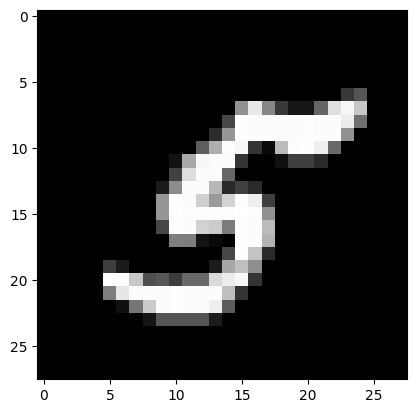

In [7]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray');

In [8]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')    # Convert into array with channel.

In [9]:
X_train.shape

(60000, 28, 28, 1)

In [10]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [11]:
# X_train = X_train / 255
X_train = (X_train - 127.5) / 127.5 # -1 to 1, provides better results in GANs

In [12]:
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [13]:
buffer_size = 60000
batch_size = 512

In [14]:
buffer_size / batch_size

117.1875

In [15]:
type(X_train)

numpy.ndarray

In [16]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)    # Buffer_SIZE specifies the number of elements from this dataset from which the new dataset will sample by shuffling. If buffer_size is entire size, then it will shuffle the full dataset.

In [17]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [18]:
X_train # Converted to tensor

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Building the generator

- Batch normalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
- Leaky Relu: https://keras.io/api/layers/activation_layers/leaky_relu/
- Activation functions: https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e
- Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

In [19]:
7*7*512

25088

In [20]:
def build_generator():
  network = tf.keras.Sequential()

  # Basically performs computations on the Random Numbers. Increases the number of neurons in dense layers if more complex images are used.
  network.add(layers.Dense(7*7*512, use_bias=False, input_shape=(256, )))   # We chose 7x7x256 as 7x4=28 which is the shape we need, then we add as many channels as needed considering complexity of the image. We use 100 as input shape because we are using random noise of 100 values. We use 100 values because it is a common practice to use 100 values. We can use any number of values, but 100 is common practice.
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU()) # negative values =  negavtive value * 0.01. Positive values remain same.

  network.add(layers.Reshape((7, 7, 512)))    # value reshape from vector to tensor for Conv2DTranspose. Dense use Vectors, Conv2D use Tensors.

  # Takes the output of the Dense layer and converts it into an image.
  # 7x7x128
  network.add(layers.Conv2DTranspose(256, (5,5), padding='same', use_bias=False)) # Normal Conv2D decreases size of image while Conv2DTranspose increases size of image. Padding=same so it is easy to manipulate size of image using strides.
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 7x7x128
  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False)) # Normal Conv2D decreases size of image while Conv2DTranspose increases size of image. Padding=same so it is easy to manipulate size of image using strides.
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias=False))   # Size increases from 7x7 to 14x14 even tho paddding is same, It is because of strides=2 which takes 2 steps, and since we are using Conv2DTranspose, it increases the size of image
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(1, (5,5), strides = (2,2), padding='same', use_bias=False, activation='tanh')) # If we used strides=1, dimensions would be same as 14x14. We use tanh activation function because we already normalized values to -1 to 1. If we used sigmoid, we would have to normalize values to 0 to 1. hence we use tanh to continue using -1 to 1.

  network.summary()

  return network

In [21]:
generator = build_generator()

d:\D-Program Files\Python\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 25088)          │     6,422,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 256)      │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,827,072 (41.30 MB)

 Trainable params: 10,776,000 (41.11 MB)

 Non-trainable params: 51,072 (199.50 KB)

In [22]:
noise = tf.random.normal([1, 256])  # Generate random numbers from -1 to 1. 1, 100 because we are generating 1 image with 100 random numbers.

In [23]:
noise

<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
array([[-1.2651552 , -1.0119379 , -0.1894258 ,  0.17496404,  0.75210434,
         0.07269958,  0.5451792 , -0.07095281,  0.02840212, -0.5837406 ,
         0.6216625 , -0.73694164,  1.4165716 ,  0.56956786, -0.69069636,
         0.7030928 , -1.3057278 , -0.14770602, -0.07460182, -0.8531026 ,
         0.36893737,  0.04662975, -0.3309767 ,  0.85914236,  0.28410733,
        -0.98786414,  0.4671013 ,  0.7807231 ,  0.8387842 ,  0.8390808 ,
        -0.36715543, -0.7028554 ,  1.8037683 ,  1.2100233 , -0.208243  ,
         0.8141243 , -0.4198605 , -1.6929044 , -0.48890224,  1.04428   ,
         1.473172  , -2.0602086 , -0.41405815, -0.7673401 ,  0.669503  ,
        -0.65864563, -1.5213925 , -0.13545579, -0.9635635 , -1.6154019 ,
         0.5448236 , -0.3471488 ,  0.6591554 ,  0.04511948, -2.0447352 ,
         0.84220034, -0.5194698 , -0.19294351, -0.32010016,  0.40109417,
        -0.8409121 , -0.4693184 ,  1.3606229 ,  0.3809801 ,  0.84878564,
 

In [24]:
generated_image = generator(noise, training = False)

In [25]:
generated_image.shape

TensorShape([1, 28, 28, 1])

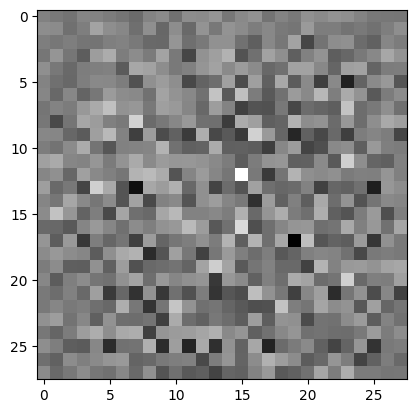

In [26]:
plt.imshow(generated_image[0,:,:,0], cmap='gray');  # Use to skip batch and channel dimensions.

## Building the discriminator

- Dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf

In [27]:
def build_discriminator():  # Seems to be the opposite of the Conv2D part of the generator.
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(256, (5,5), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(64, (5,5), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))  # Since it is binary classification, we use 1 output. Since we need to know if it is real or fake. No activation function used as this acts as a sigmoid function as it is binary classification, returning values in 0-1.

  network.summary()

  return network

In [28]:
7 * 7 * 128

6272

In [29]:
discriminator = build_discriminator()

d:\D-Program Files\Python\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 512)      │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 256)      │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 64)       │       409,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         3,137 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,511,233 (17.21 MB)

 Trainable params: 4,511,233 (17.21 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
discriminator(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.0004997]], dtype=float32)>

## Calculating the loss

- Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [31]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)    # We use from_logits=True because we are using the output of the last layer of the discriminator which does not have an activation function. cross_entropy is used to calculate the loss.

In [32]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [33]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [34]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5, beta_2=0.999)   # For GANs, it is perferred to use lower learning rate. We use 0.00001 because we are using Adam optimizer.
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00004, beta_1=0.5, beta_2=0.999)

## Training the model

In [35]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [36]:
epochs = 100
noise_dim = 256
num_images_to_generate = 16

In [37]:
batch_size, noise_dim

(512, 256)

In [38]:
import os

# Define the folder where weights will be saved
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


# Enable eager execution globally
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [39]:
@tf.function
def train_steps(images, epoch):
  noise = tf.random.normal([batch_size, noise_dim]) # get as many batches of random numbers as there are batches of training dataset.
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [40]:
test_images = tf.random.normal([num_images_to_generate, noise_dim])

In [41]:
test_images.shape

TensorShape([16, 256])

In [42]:
60000 / 256

234.375

In [43]:
# generator.save_weights(f"{checkpoint_dir}/generator_weights_epoch_{95}.weights.h5")
# discriminator.save_weights(f"{checkpoint_dir}/discriminator_weights_epoch_{95}.weights.h5")

In [48]:
import os

# Verify if the file exists
file_path = "checkpoints/generator_weights_epoch_90.weights.h5"
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    print(f"File exists: {file_path}")


File exists: checkpoints/generator_weights_epoch_90.weights.h5


In [50]:
# Load the weights into the generator and discriminator models
checkpoint_dir = 'checkpoints'
generator.load_weights(f"checkpoints/generator_weights_epoch_90.weights.h5")
discriminator.load_weights(f"checkpoints/discriminator_weights_epoch_90.weights.h5")

OSError: Unable to synchronously open file (file signature not found)

In [43]:
def train(dataset, epochs, test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      #print(image_batch.shape)
      train_steps(image_batch, epoch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

      # Save model weights every 5 epochs
    if epoch % 5 == 0:
      gen_file = f"{checkpoint_dir}/generator_weights_epoch_{epoch}.weights.h5"
      disc_file = f"{checkpoint_dir}/discriminator_weights_epoch_{epoch}.weights.h5"
      
      # Save generator and discriminator weights
      generator.save_weights(gen_file)
      discriminator.save_weights(disc_file)
      
      # Close the files
      with open(gen_file, 'w') as file:
          file.close()
      with open(disc_file, 'w') as file:
          file.close()

    print(f"Weights saved and files closed for epoch {epoch}")

Epoch:  1


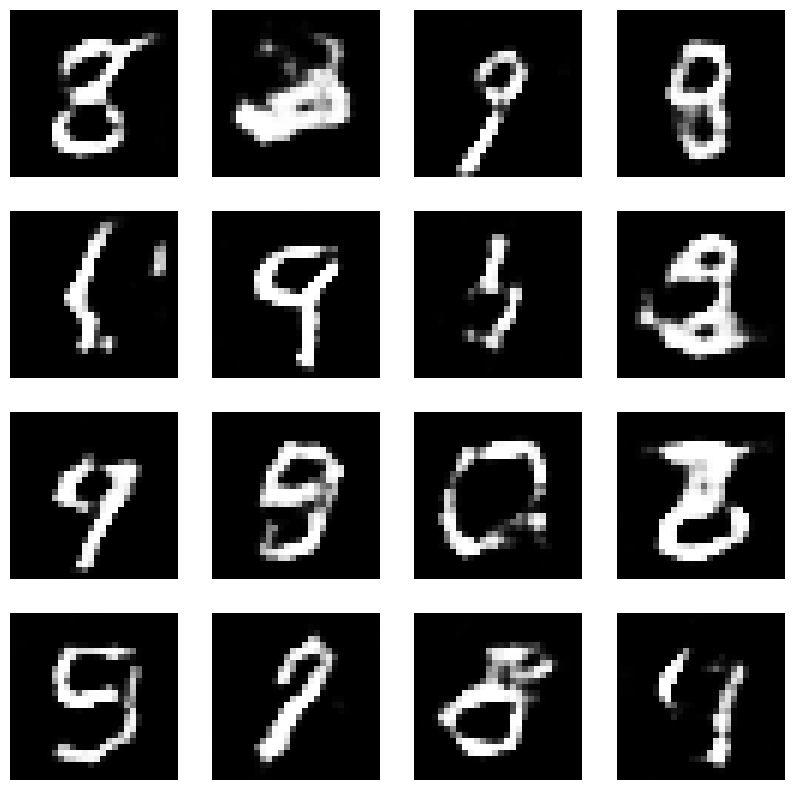

Weights saved and files closed for epoch 0
Epoch:  2


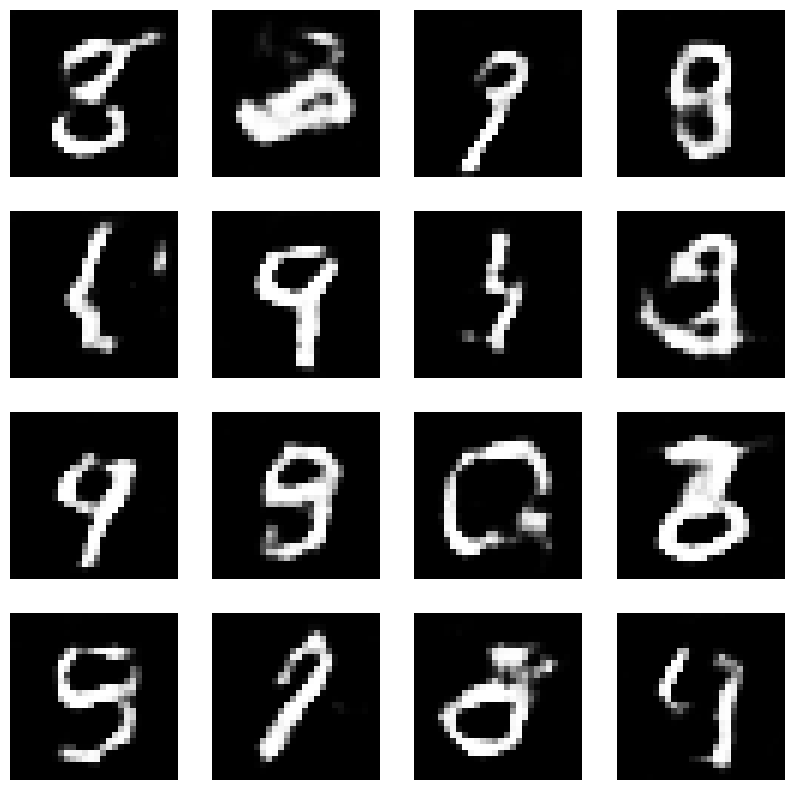

Weights saved and files closed for epoch 1
Epoch:  3


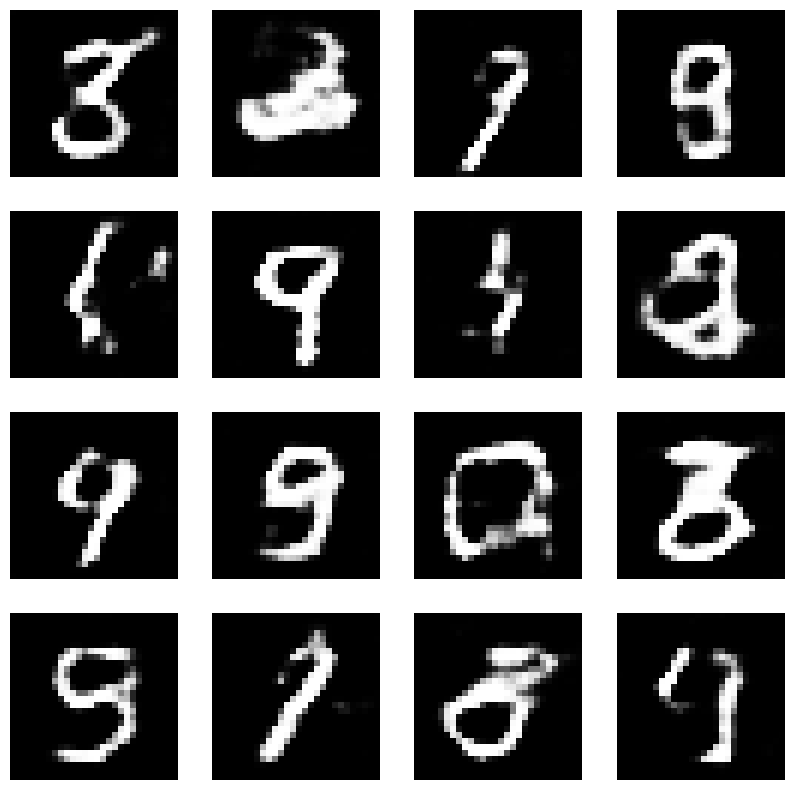

Weights saved and files closed for epoch 2
Epoch:  4


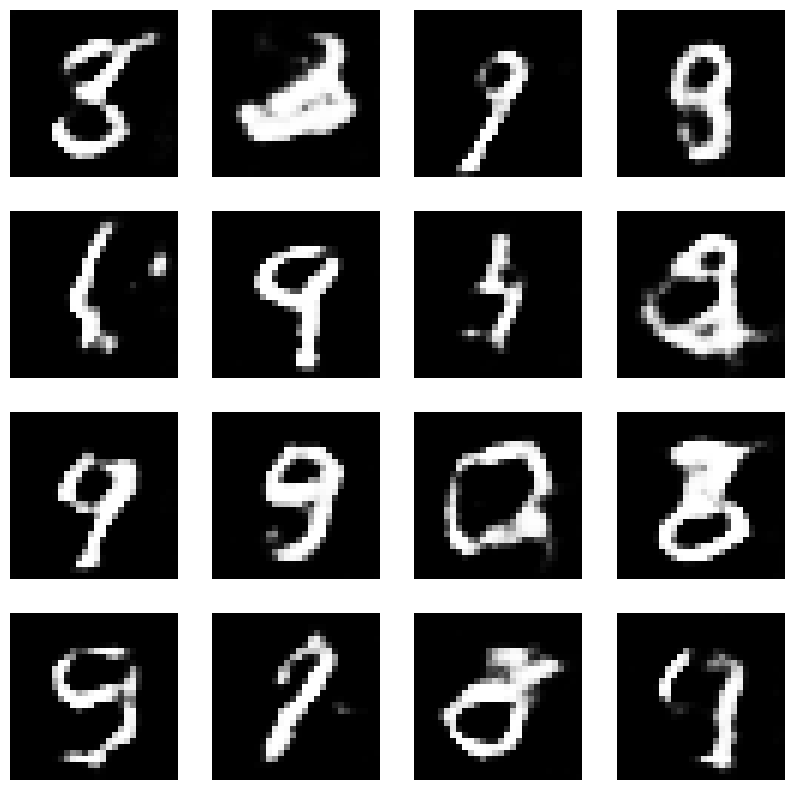

Weights saved and files closed for epoch 3
Epoch:  5


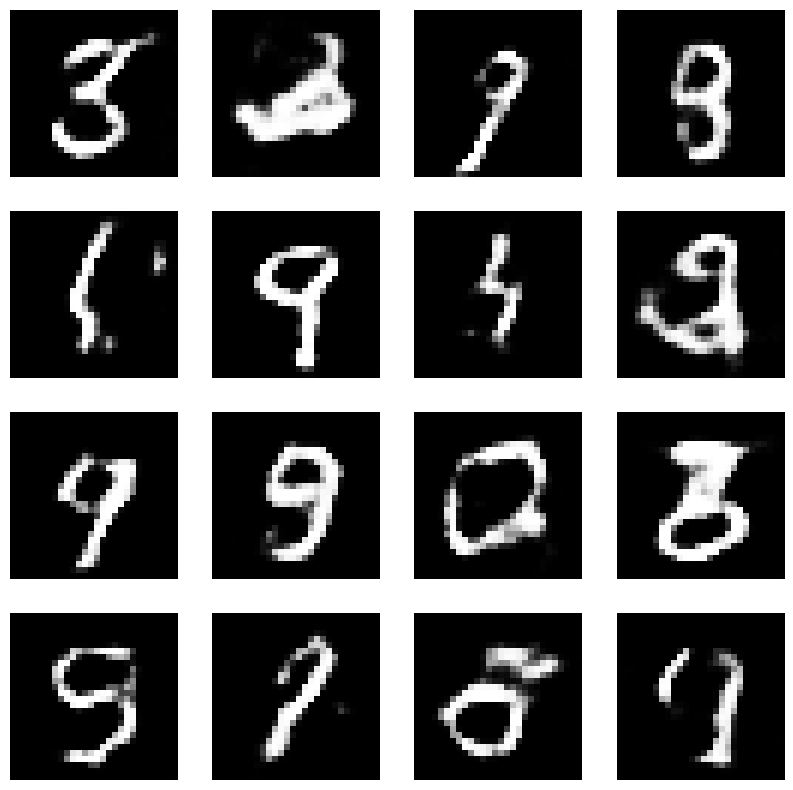

Weights saved and files closed for epoch 4
Epoch:  6


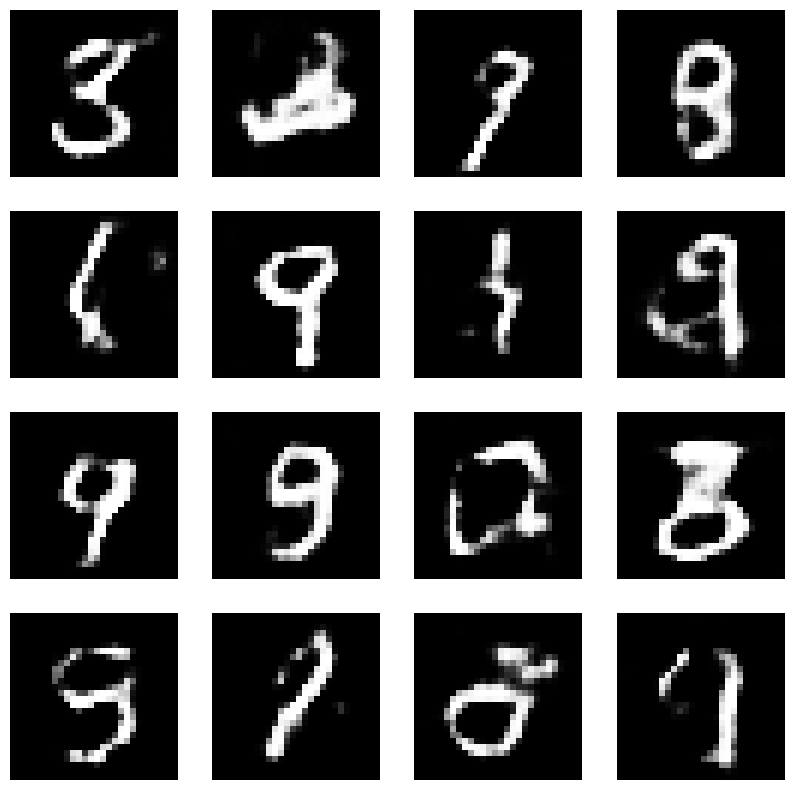

Weights saved and files closed for epoch 5
Epoch:  7


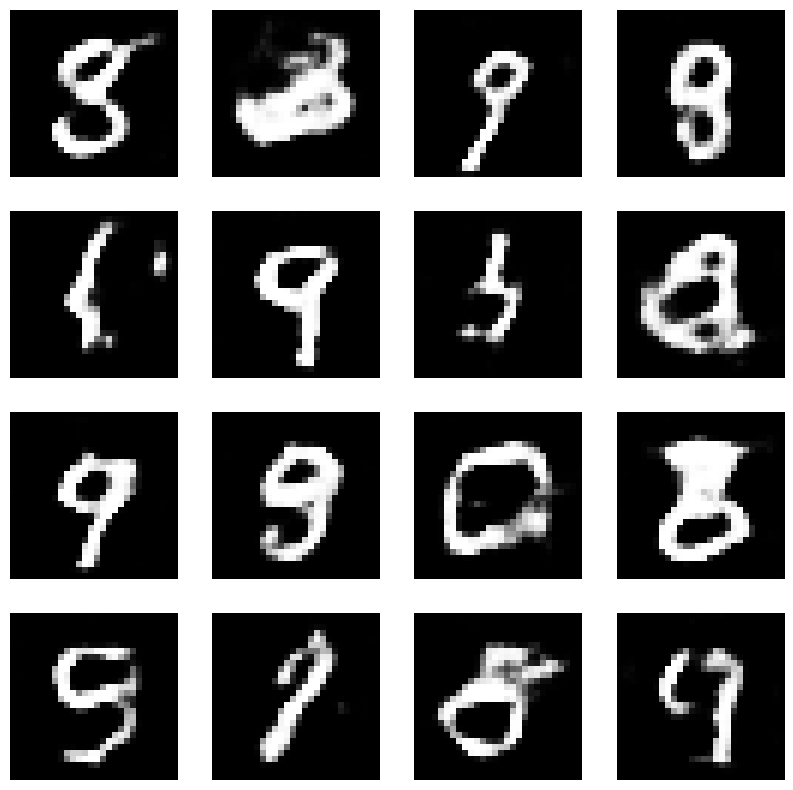

Weights saved and files closed for epoch 6
Epoch:  8


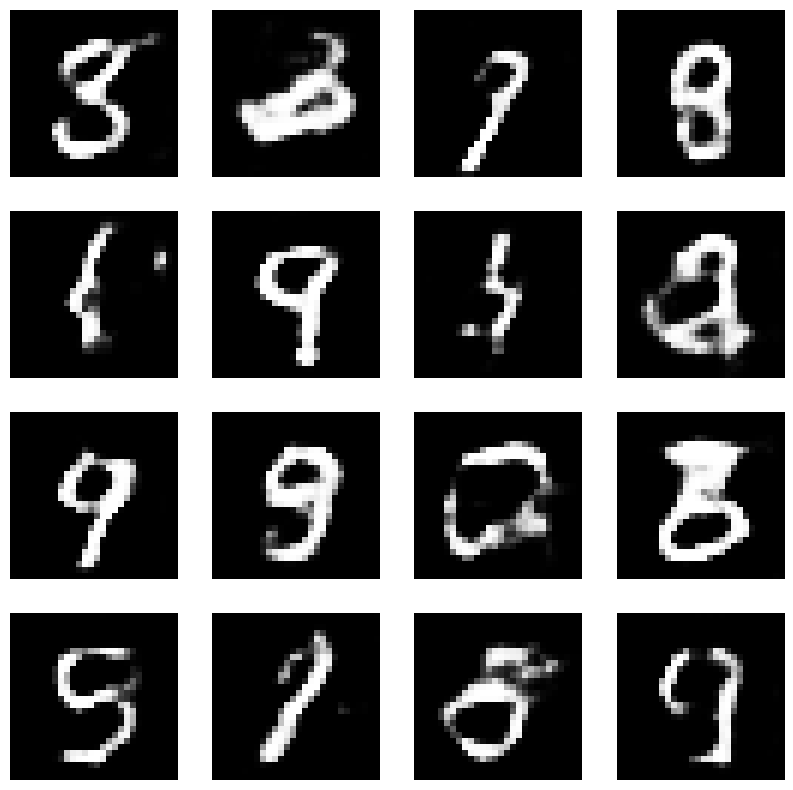

Weights saved and files closed for epoch 7
Epoch:  9


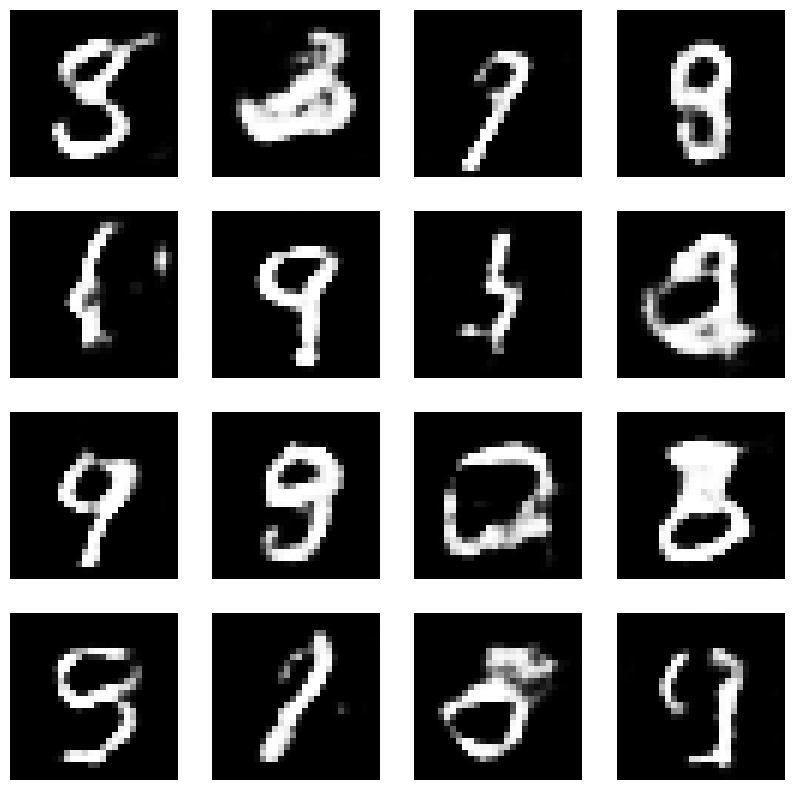

Weights saved and files closed for epoch 8
Epoch:  10


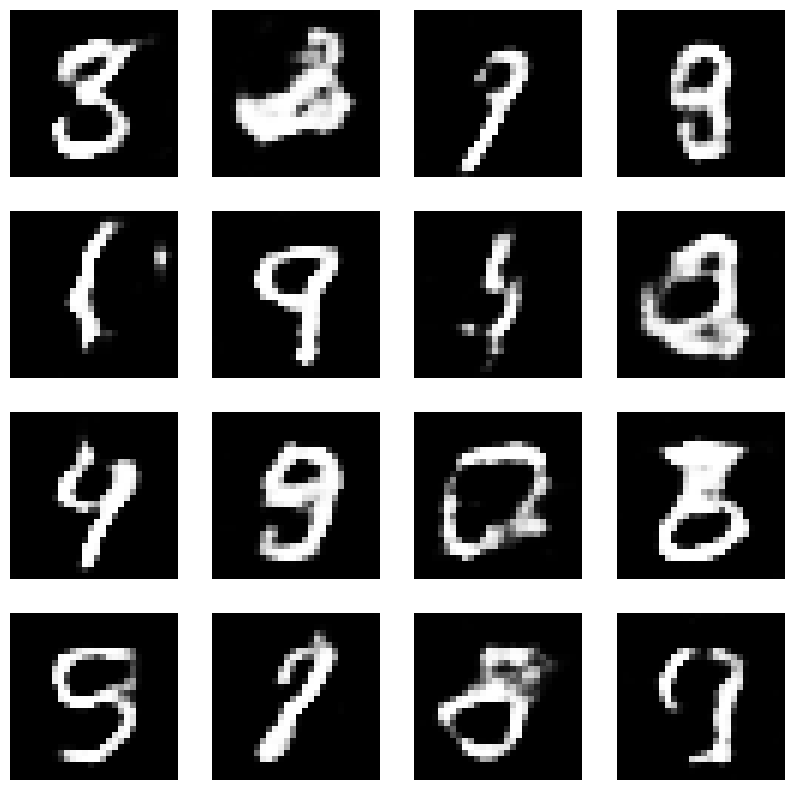

Weights saved and files closed for epoch 9
Epoch:  11


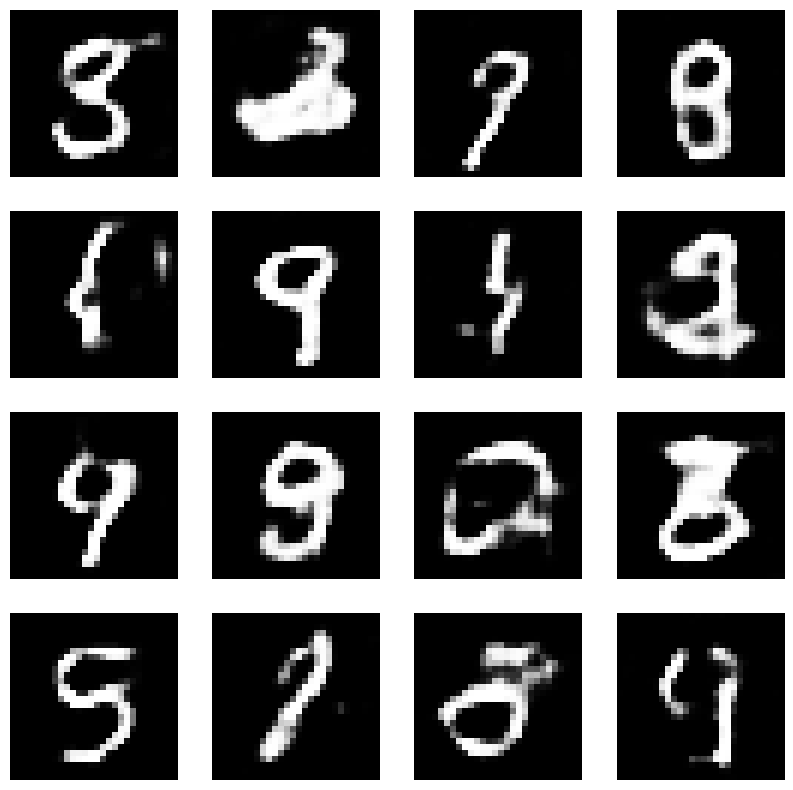

Weights saved and files closed for epoch 10
Epoch:  12


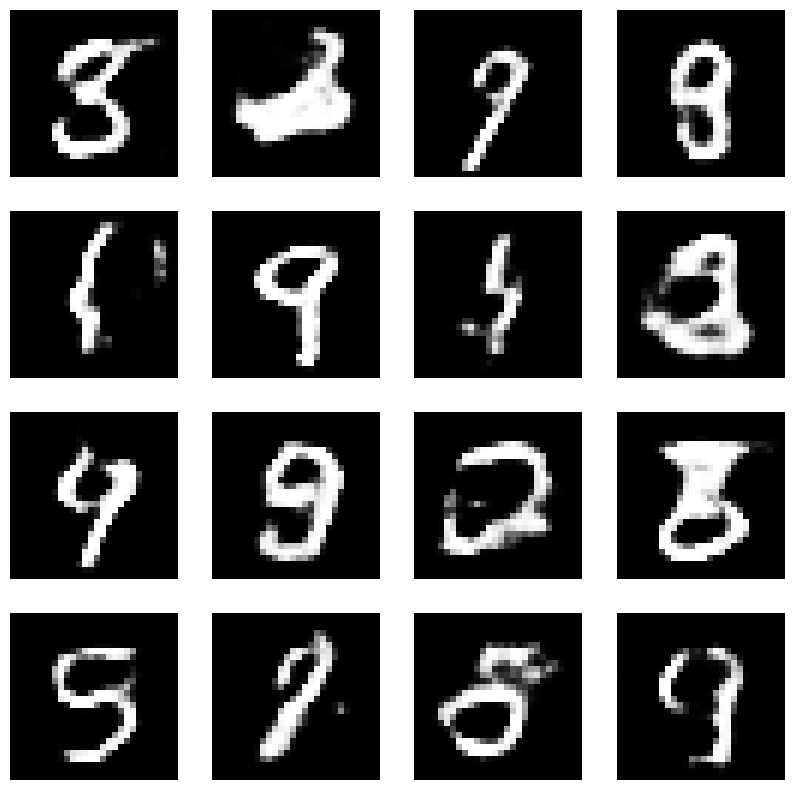

Weights saved and files closed for epoch 11
Epoch:  13


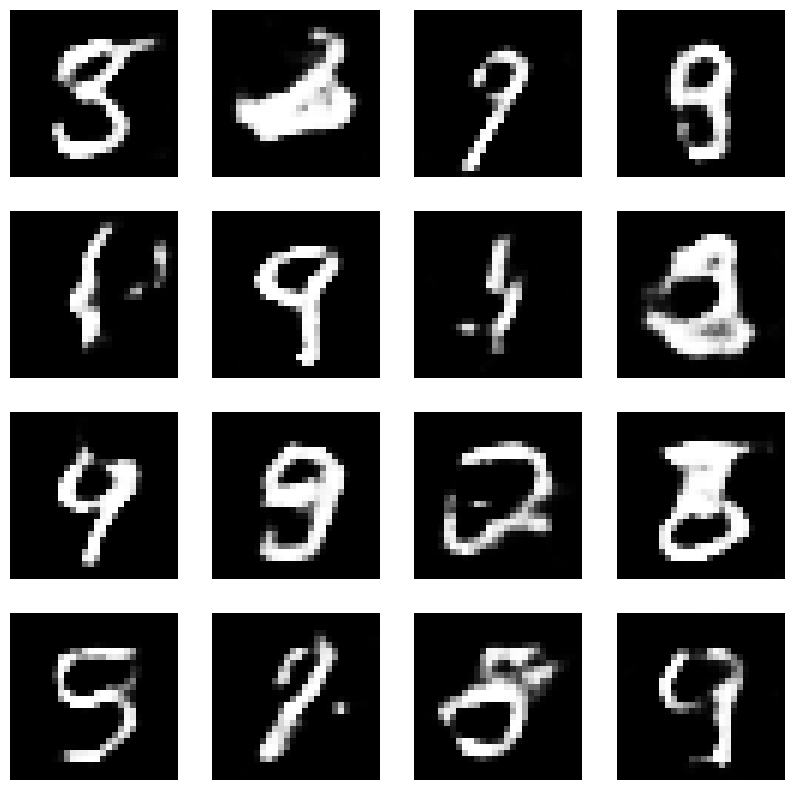

Weights saved and files closed for epoch 12
Epoch:  14


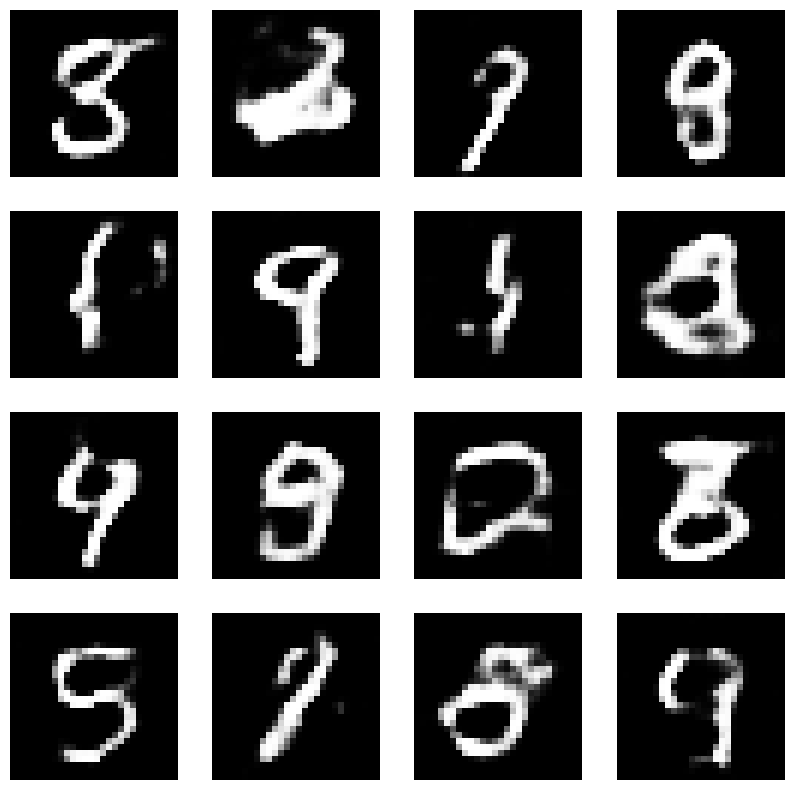

Weights saved and files closed for epoch 13
Epoch:  15


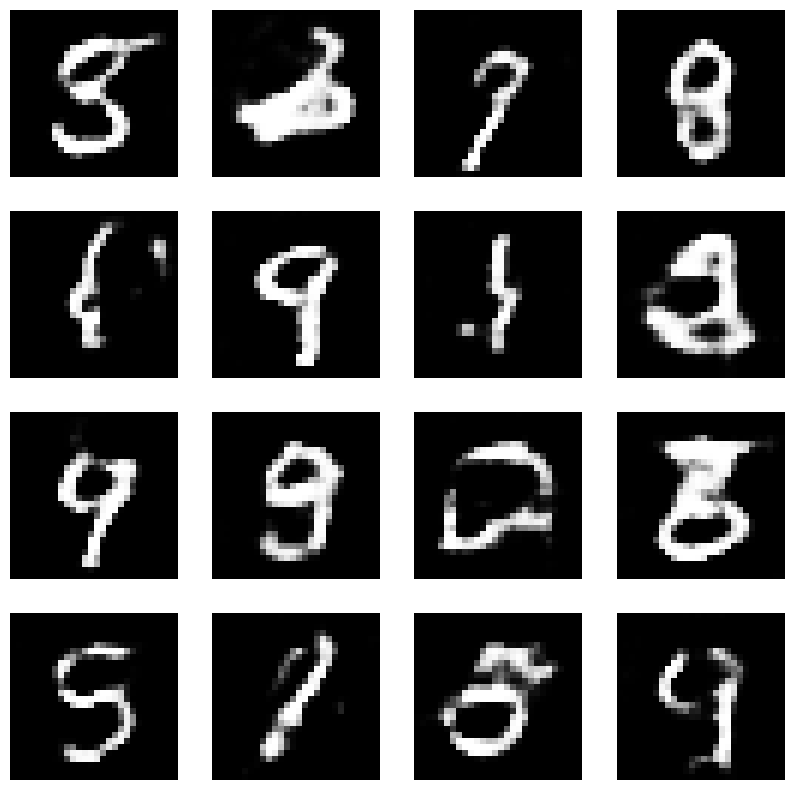

Weights saved and files closed for epoch 14
Epoch:  16


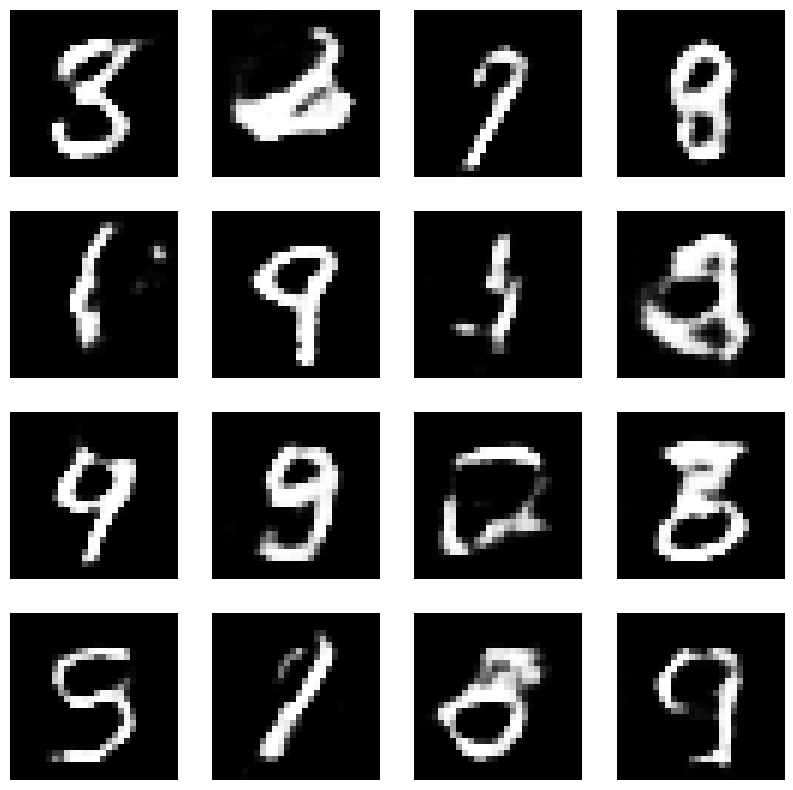

Weights saved and files closed for epoch 15
Epoch:  17


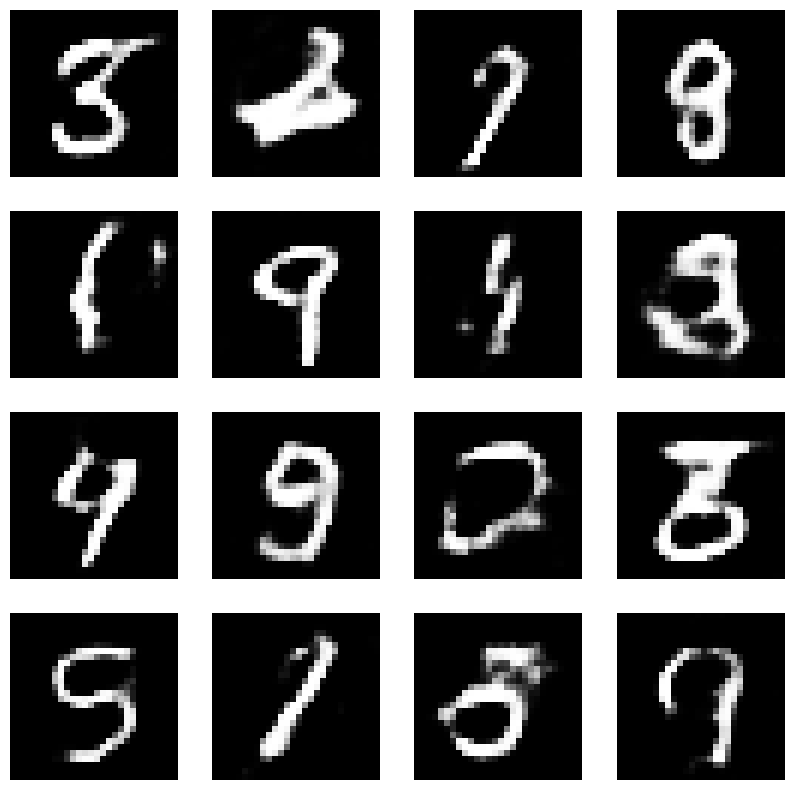

Weights saved and files closed for epoch 16
Epoch:  18


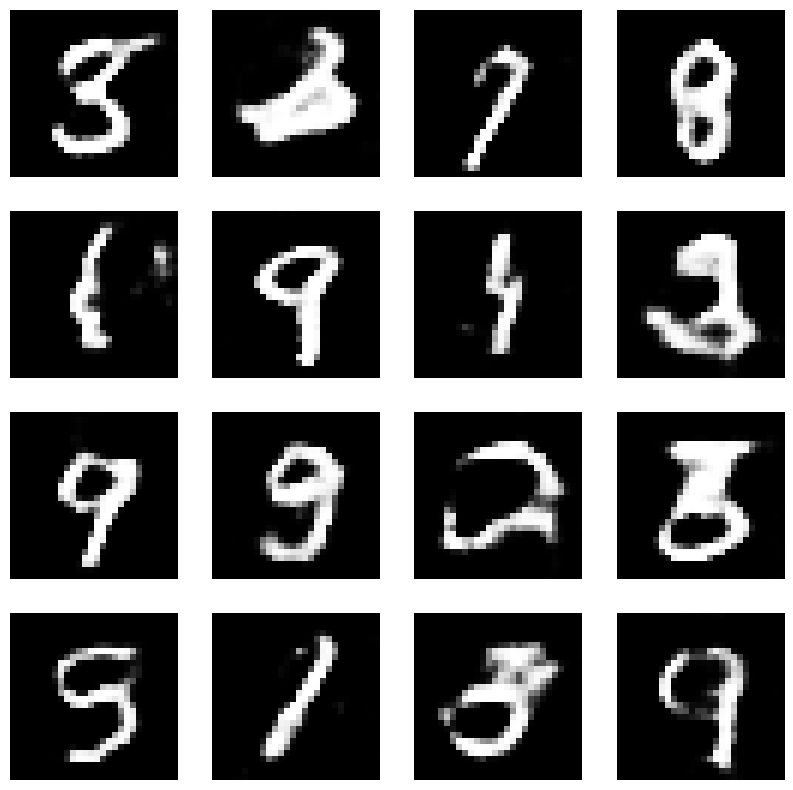

Weights saved and files closed for epoch 17
Epoch:  19


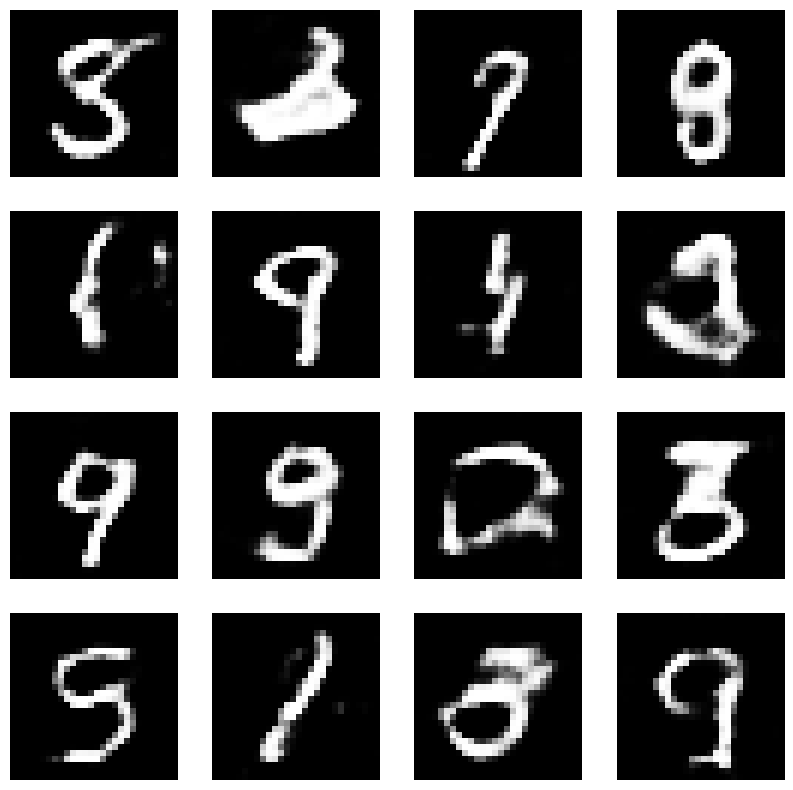

Weights saved and files closed for epoch 18
Epoch:  20


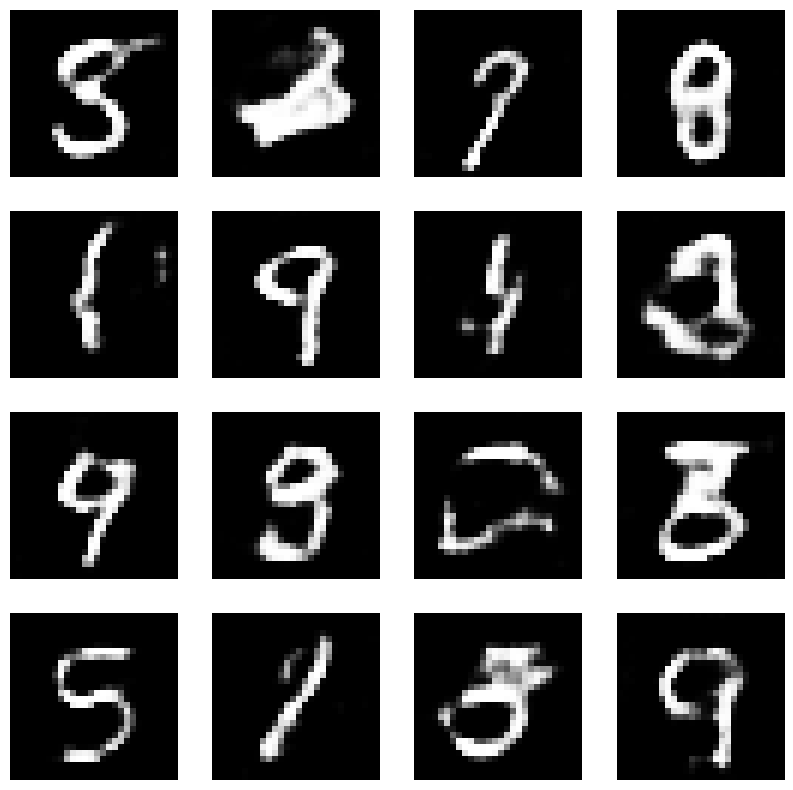

Weights saved and files closed for epoch 19
Epoch:  21


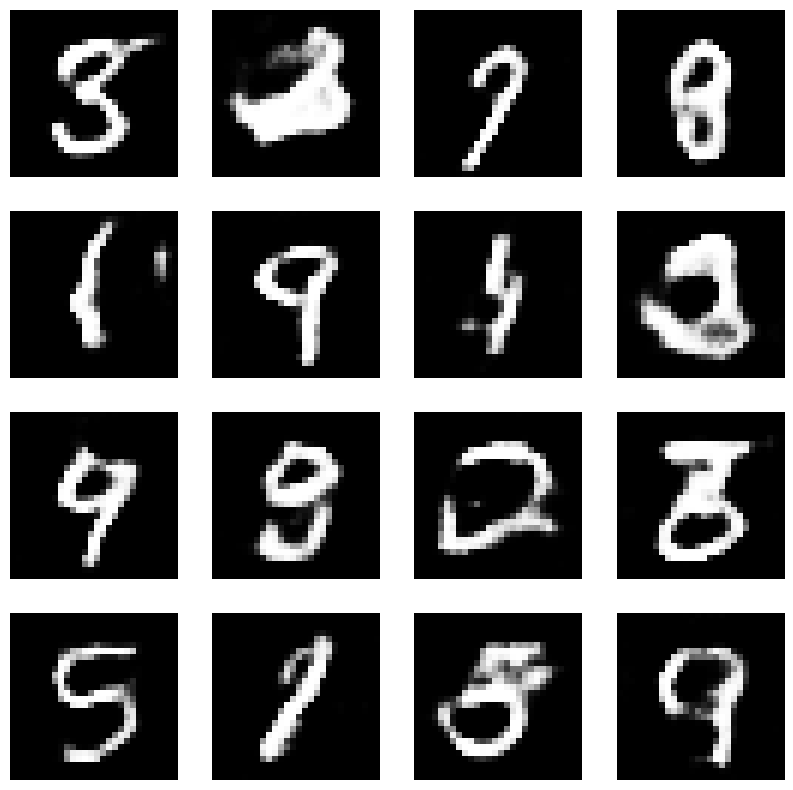

Weights saved and files closed for epoch 20
Epoch:  22


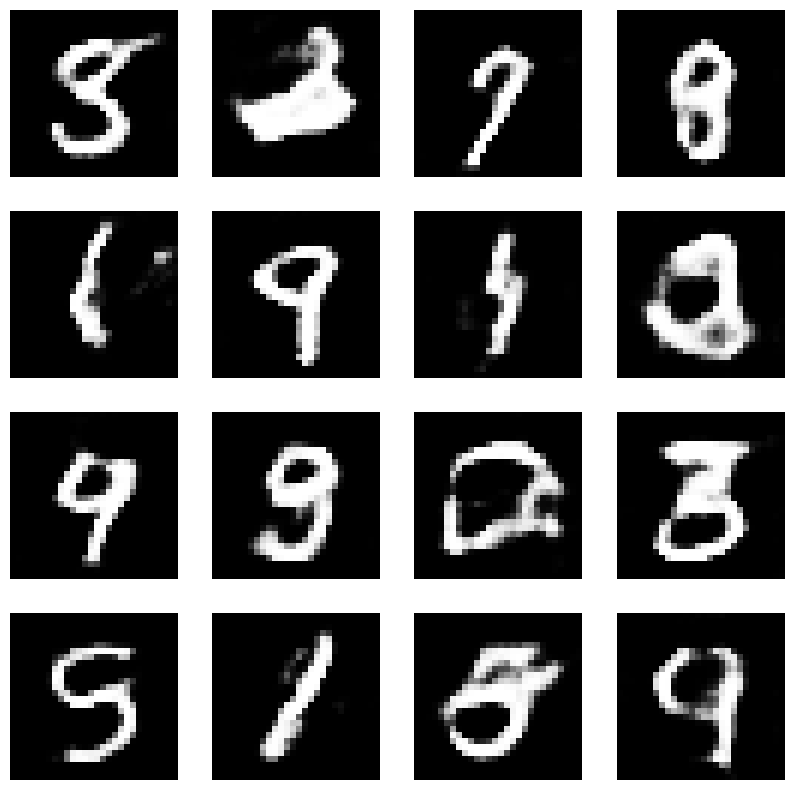

Weights saved and files closed for epoch 21
Epoch:  23


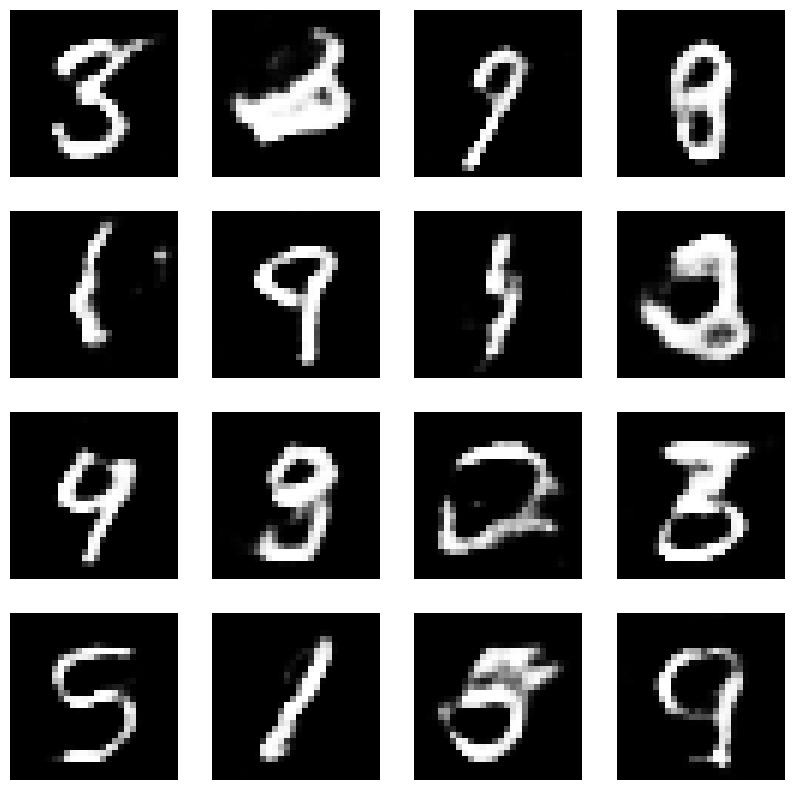

Weights saved and files closed for epoch 22
Epoch:  24


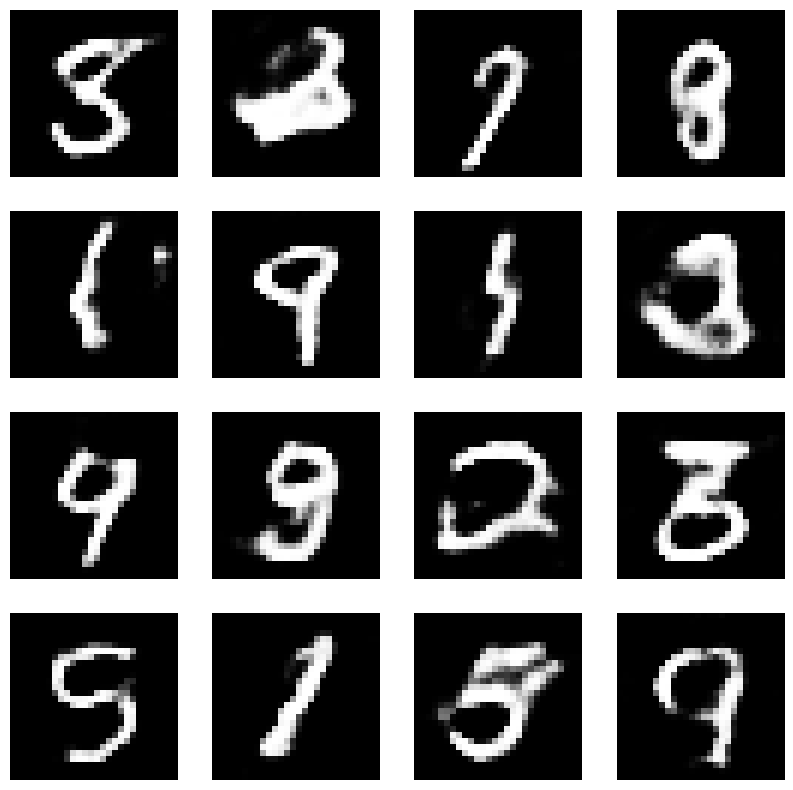

Weights saved and files closed for epoch 23
Epoch:  25


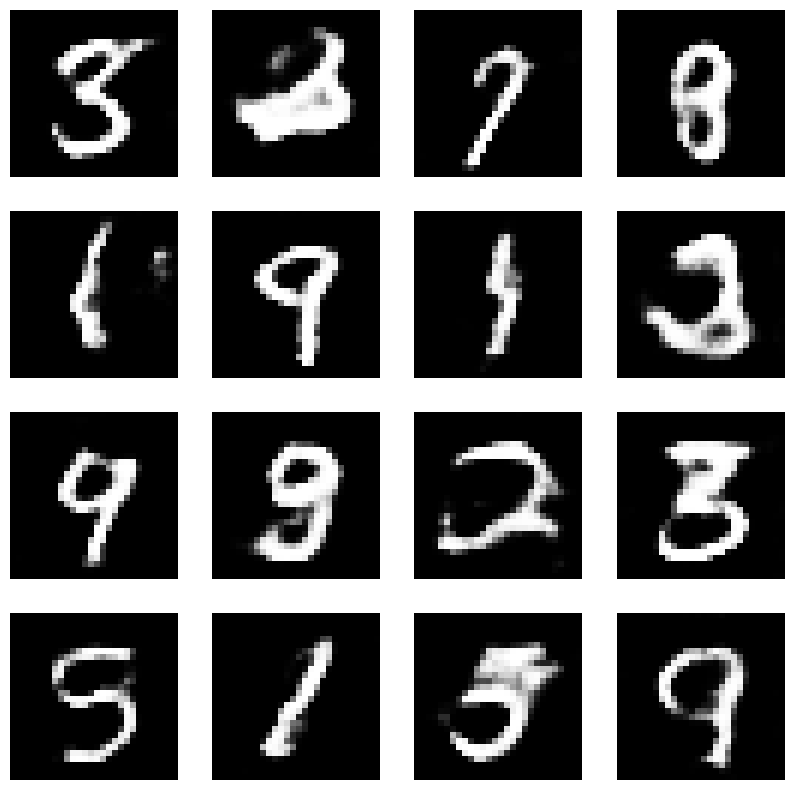

Weights saved and files closed for epoch 24
Epoch:  26


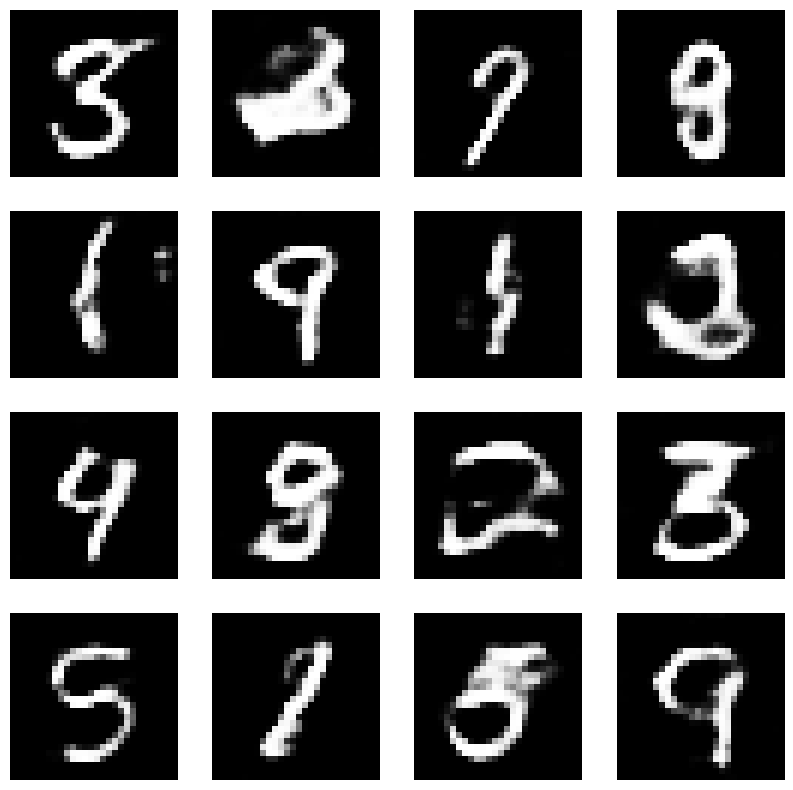

Weights saved and files closed for epoch 25
Epoch:  27


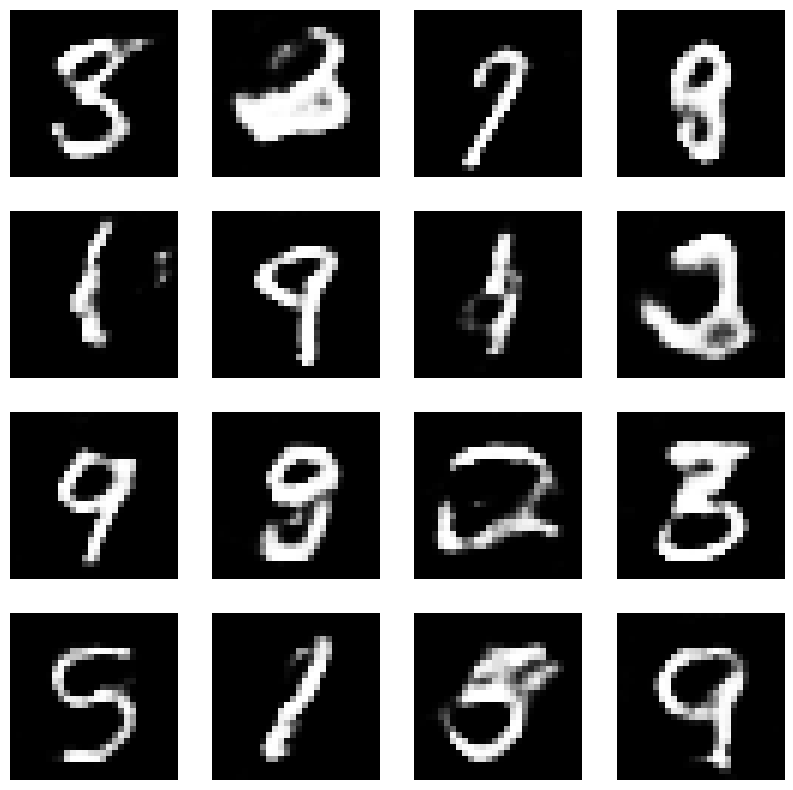

Weights saved and files closed for epoch 26
Epoch:  28


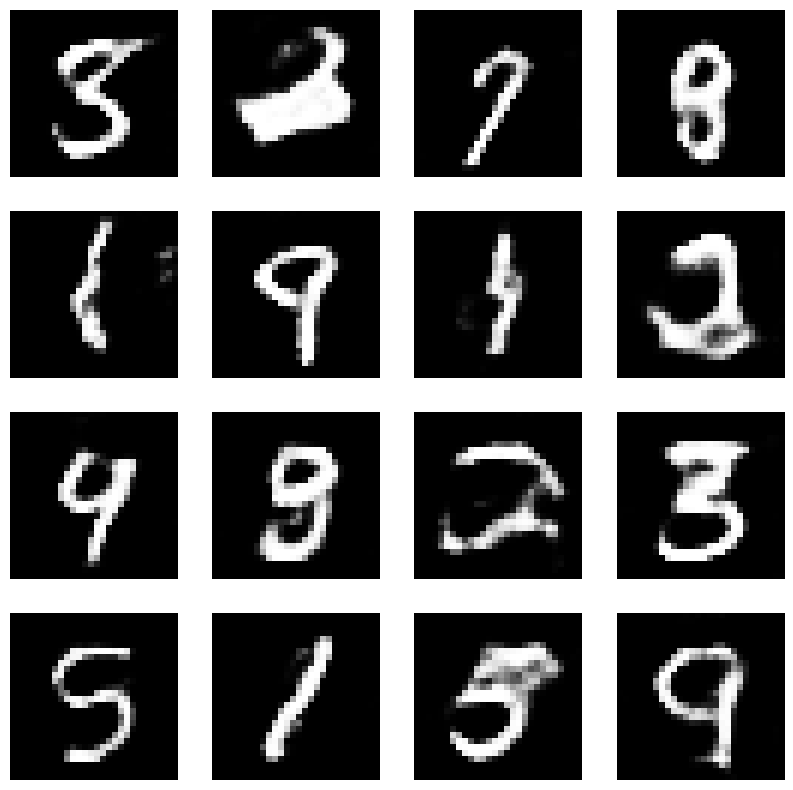

Weights saved and files closed for epoch 27
Epoch:  29


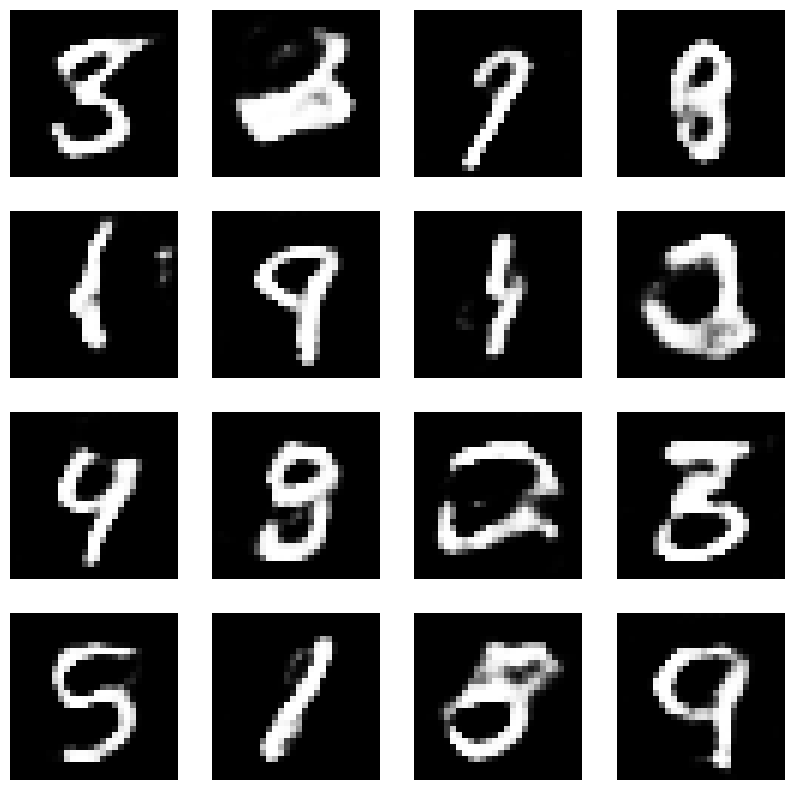

Weights saved and files closed for epoch 28
Epoch:  30


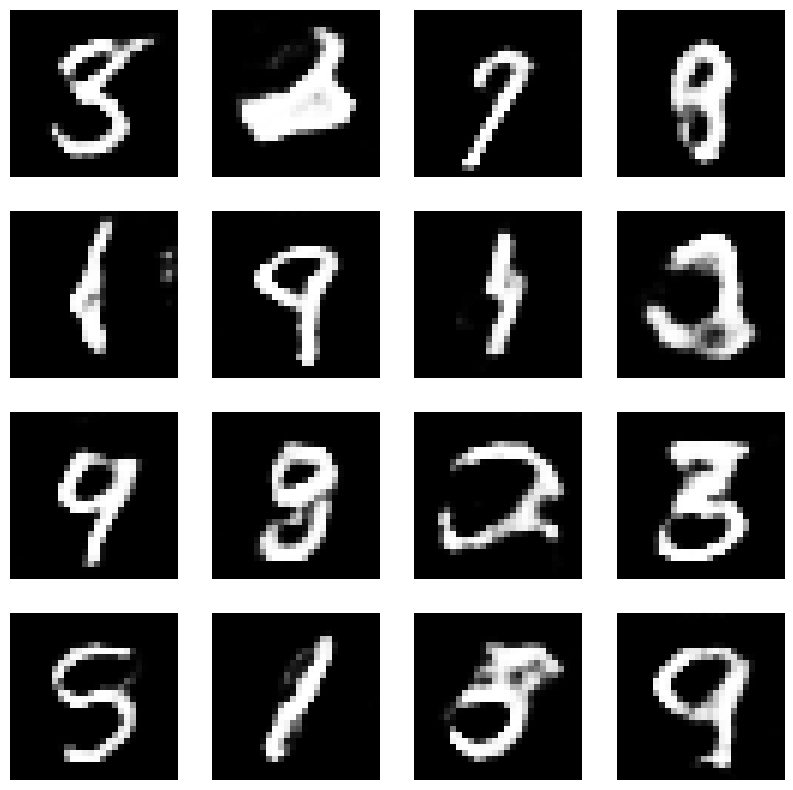

Weights saved and files closed for epoch 29
Epoch:  31


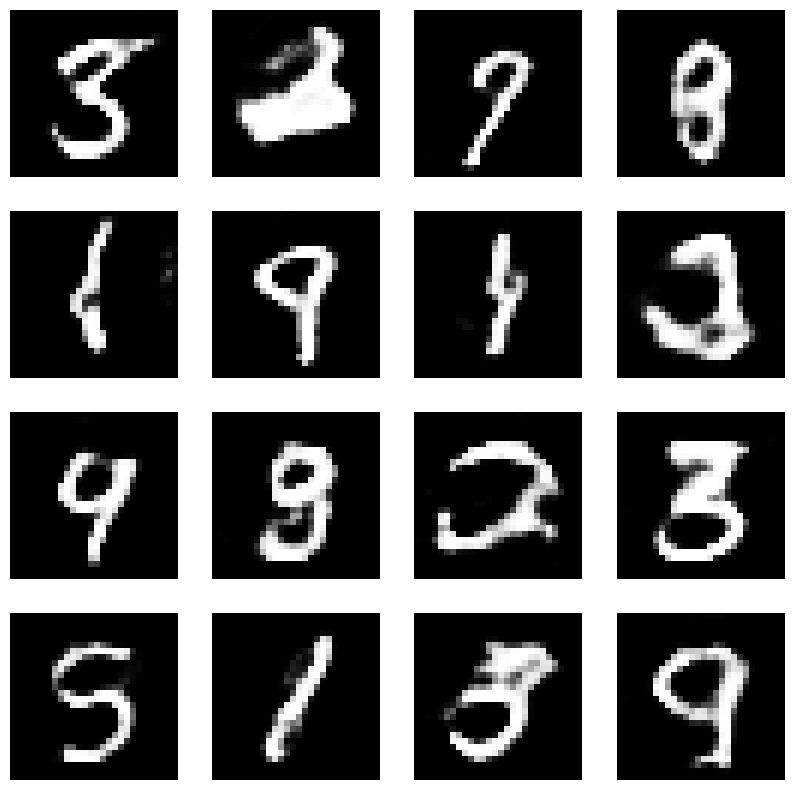

Weights saved and files closed for epoch 30
Epoch:  32


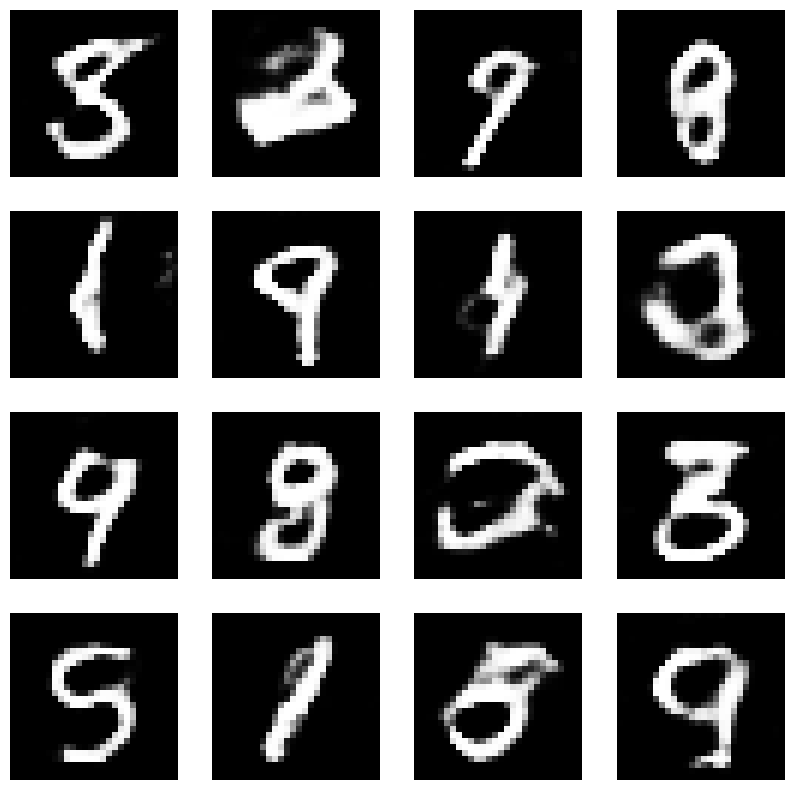

Weights saved and files closed for epoch 31
Epoch:  33


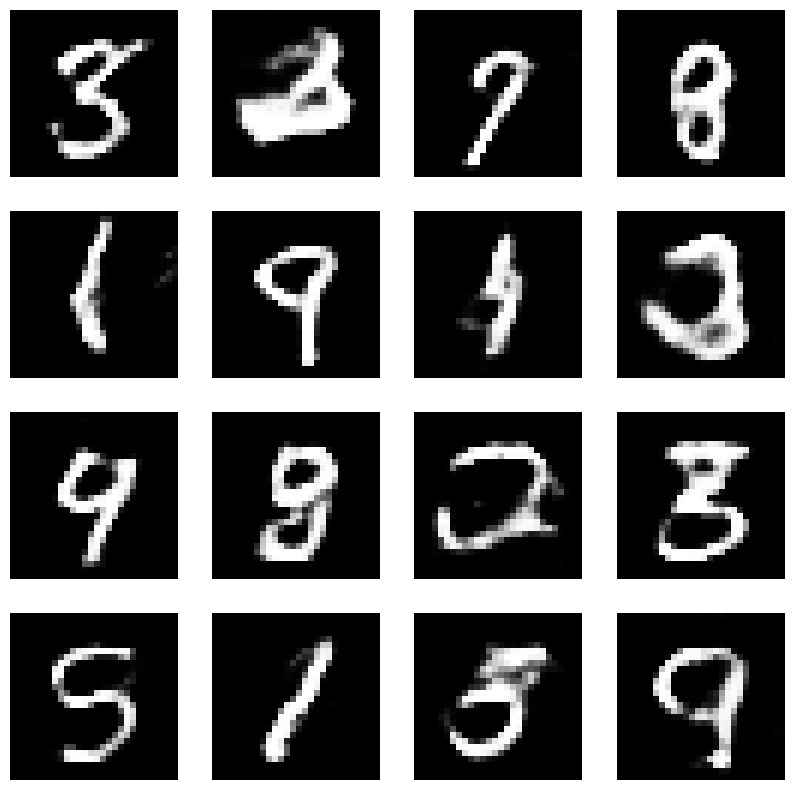

Weights saved and files closed for epoch 32
Epoch:  34


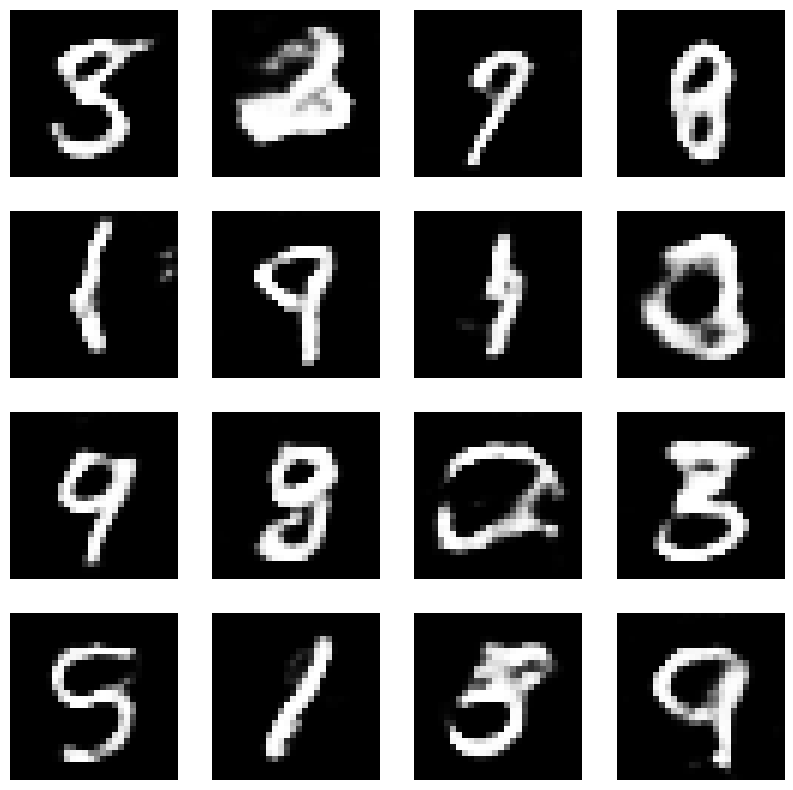

Weights saved and files closed for epoch 33
Epoch:  35


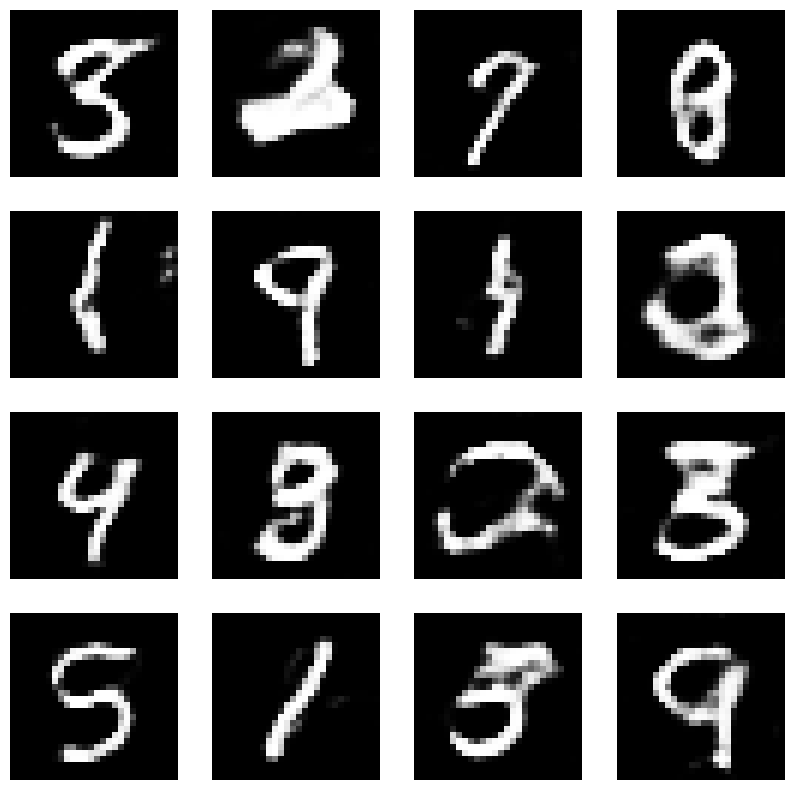

Weights saved and files closed for epoch 34
Epoch:  36


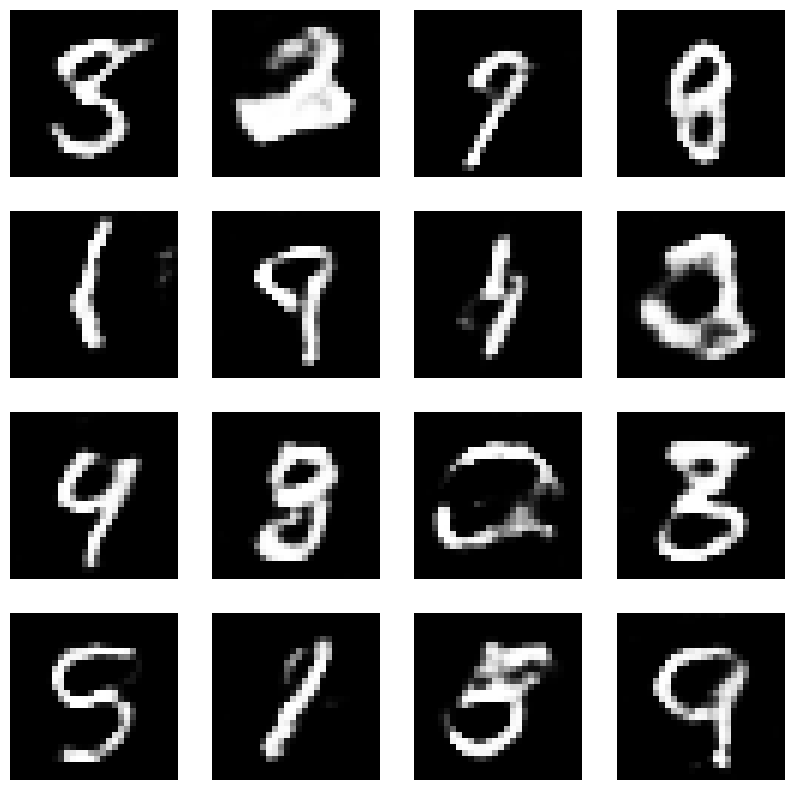

Weights saved and files closed for epoch 35
Epoch:  37


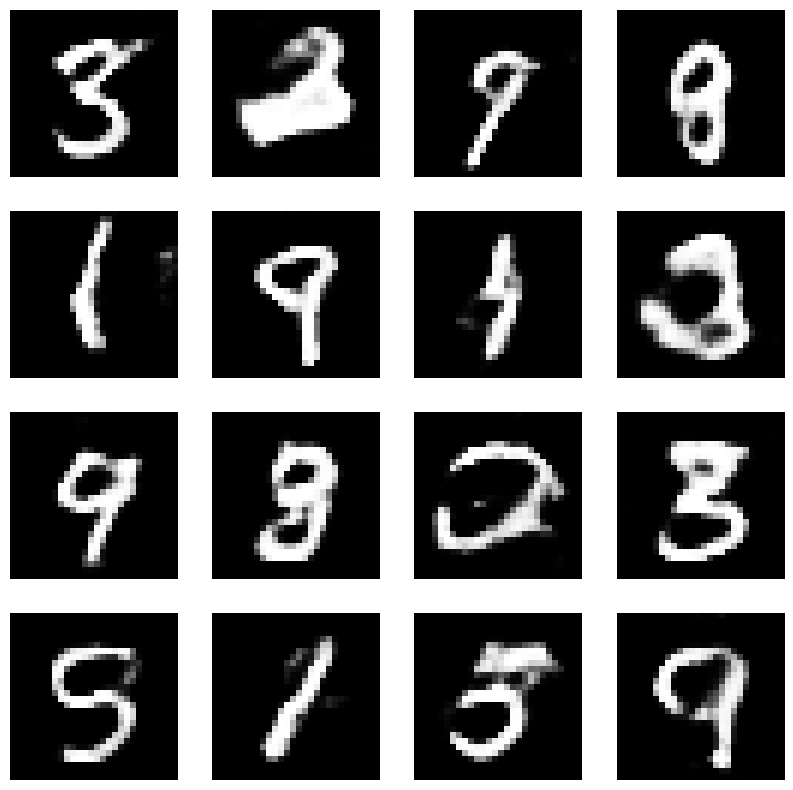

Weights saved and files closed for epoch 36
Epoch:  38


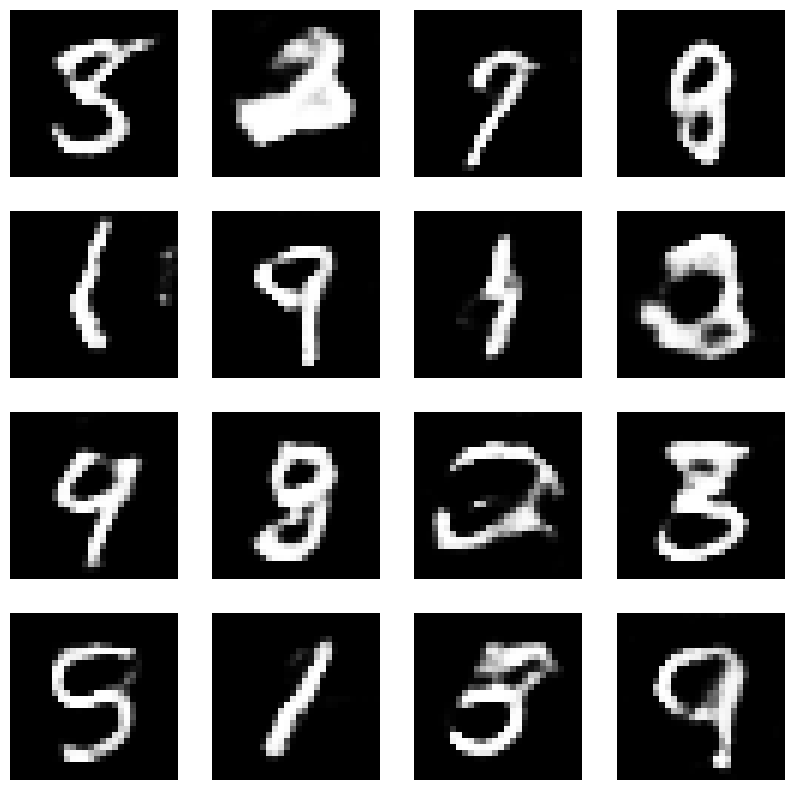

Weights saved and files closed for epoch 37
Epoch:  39


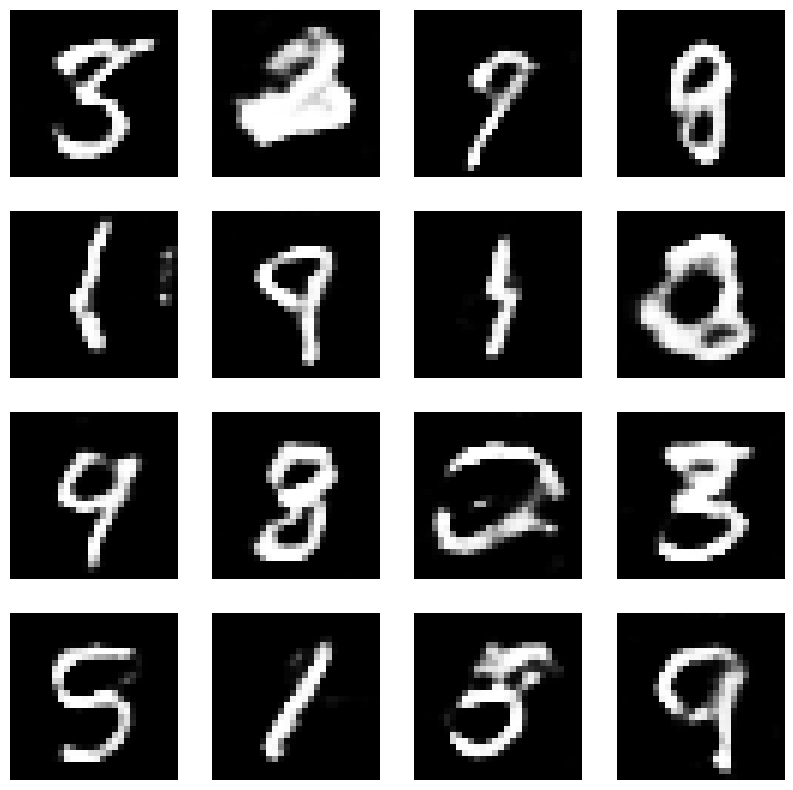

Weights saved and files closed for epoch 38
Epoch:  40


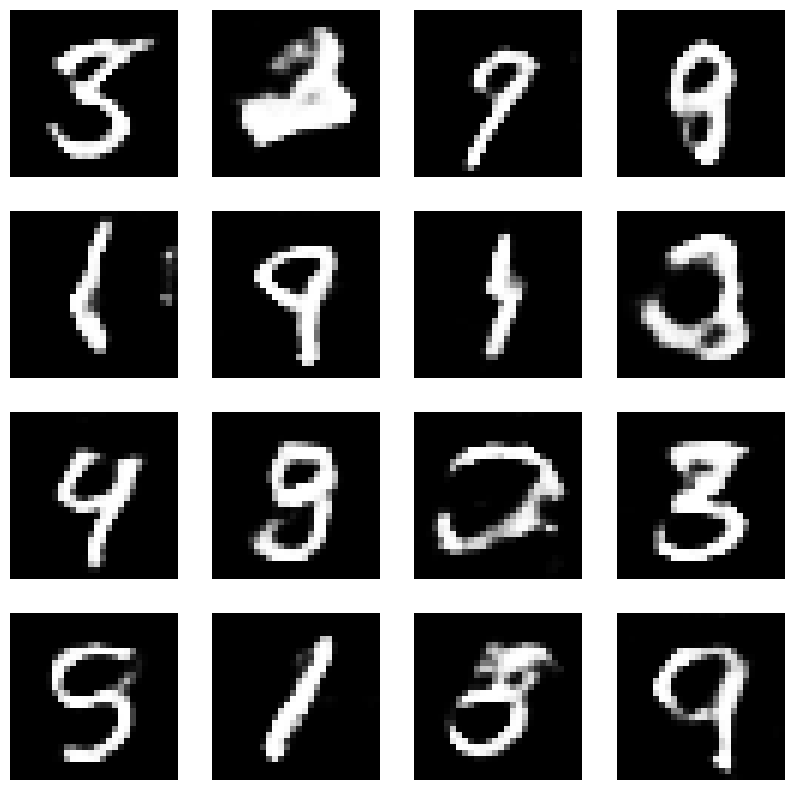

Weights saved and files closed for epoch 39
Epoch:  41


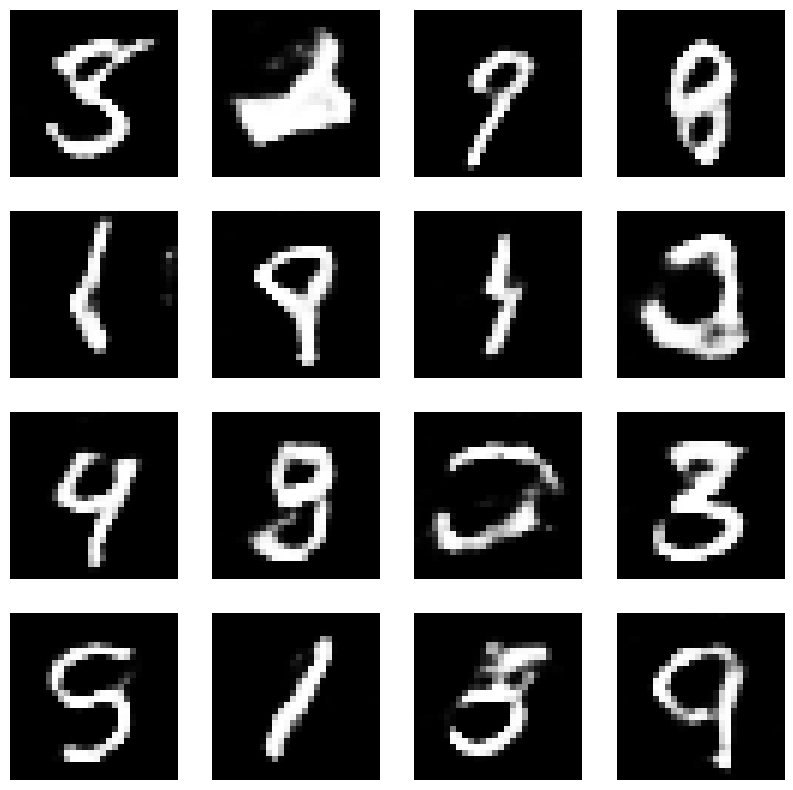

Weights saved and files closed for epoch 40
Epoch:  42


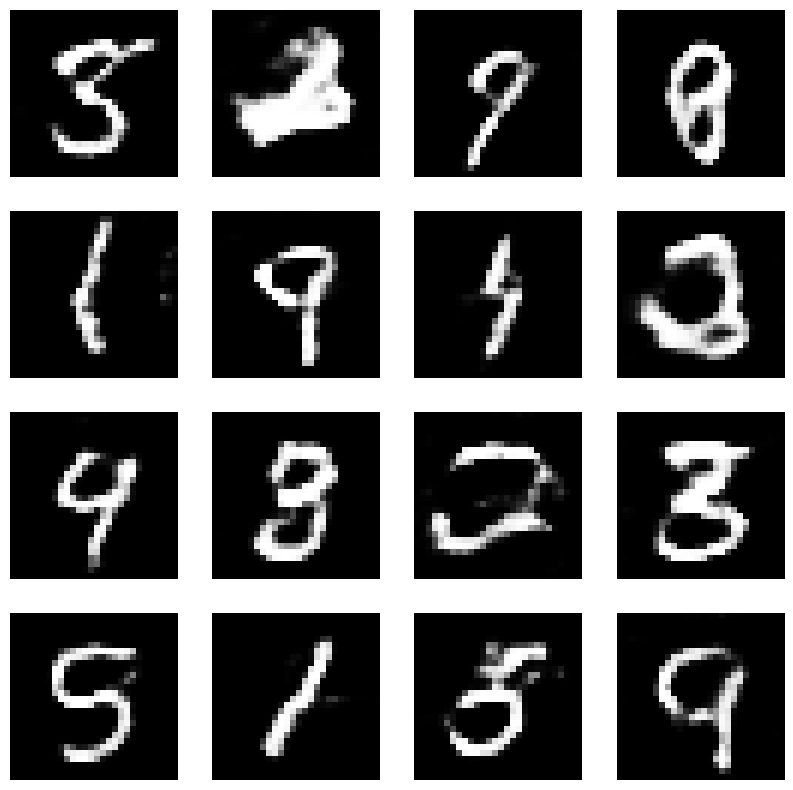

Weights saved and files closed for epoch 41
Epoch:  43


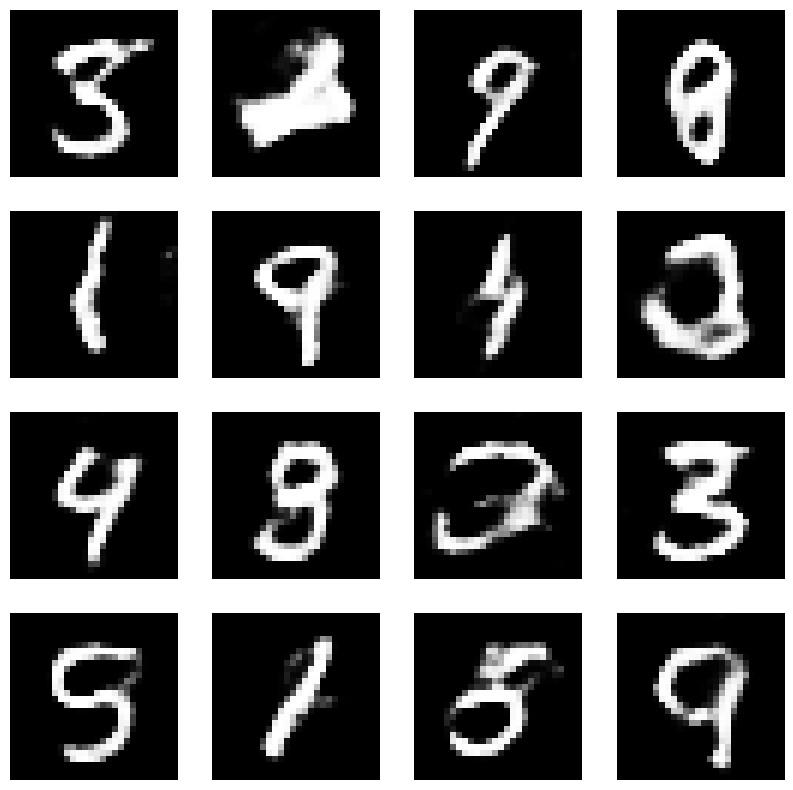

Weights saved and files closed for epoch 42
Epoch:  44


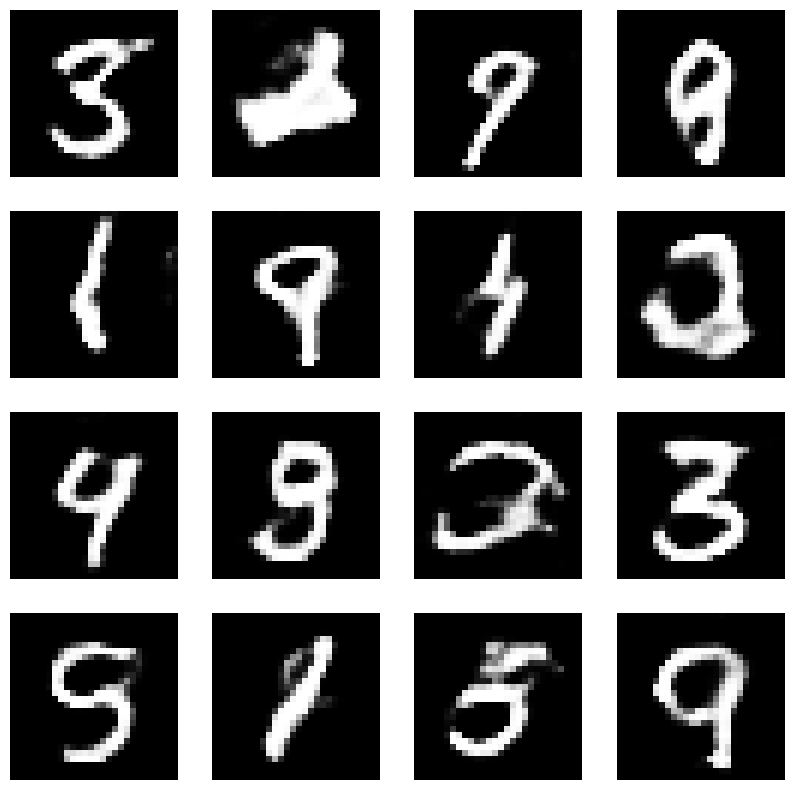

Weights saved and files closed for epoch 43
Epoch:  45


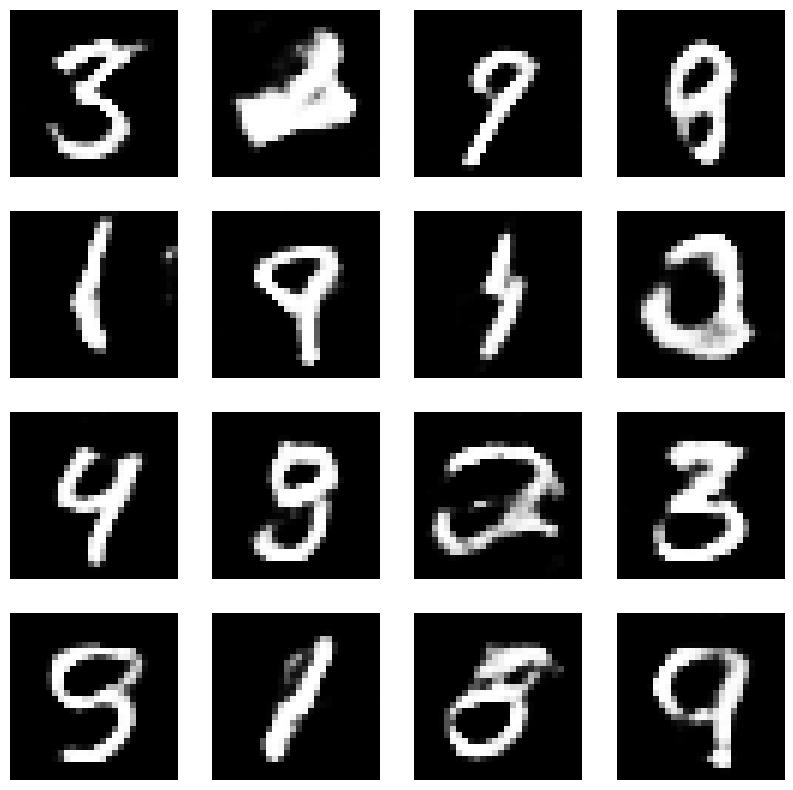

Weights saved and files closed for epoch 44
Epoch:  46


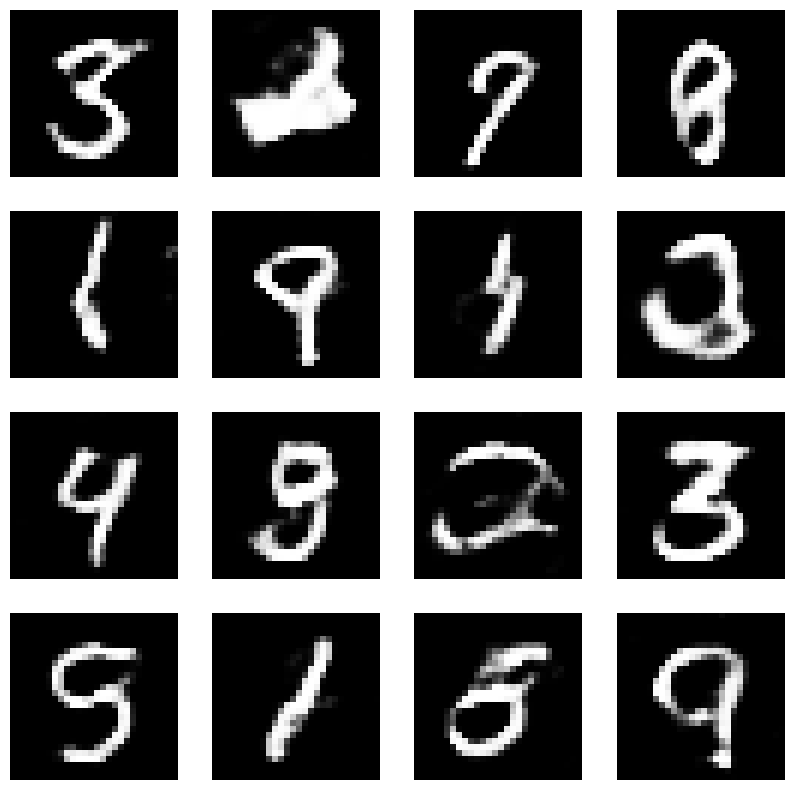

Weights saved and files closed for epoch 45
Epoch:  47


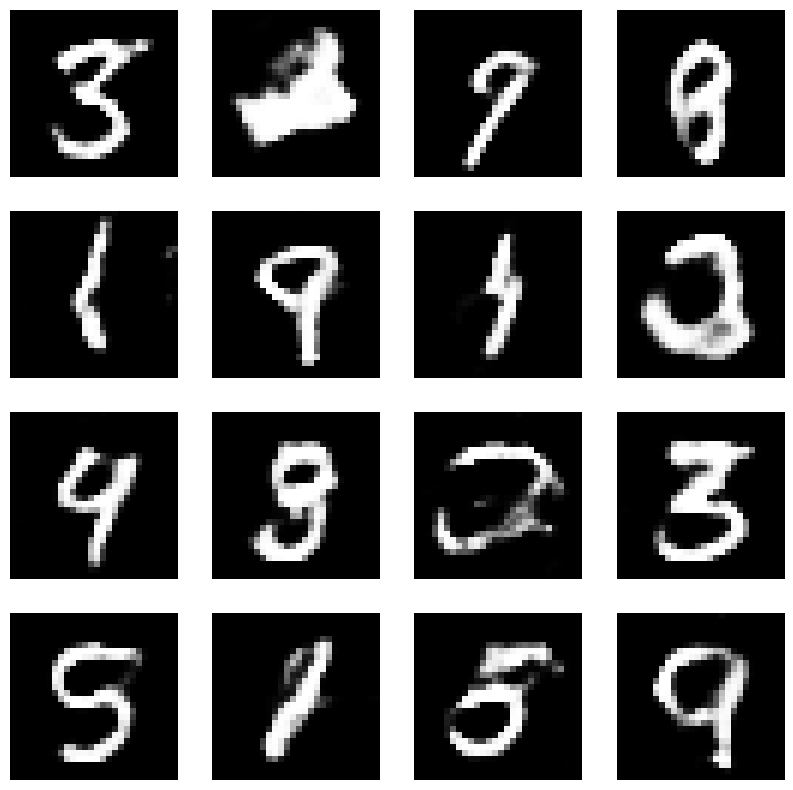

Weights saved and files closed for epoch 46
Epoch:  48


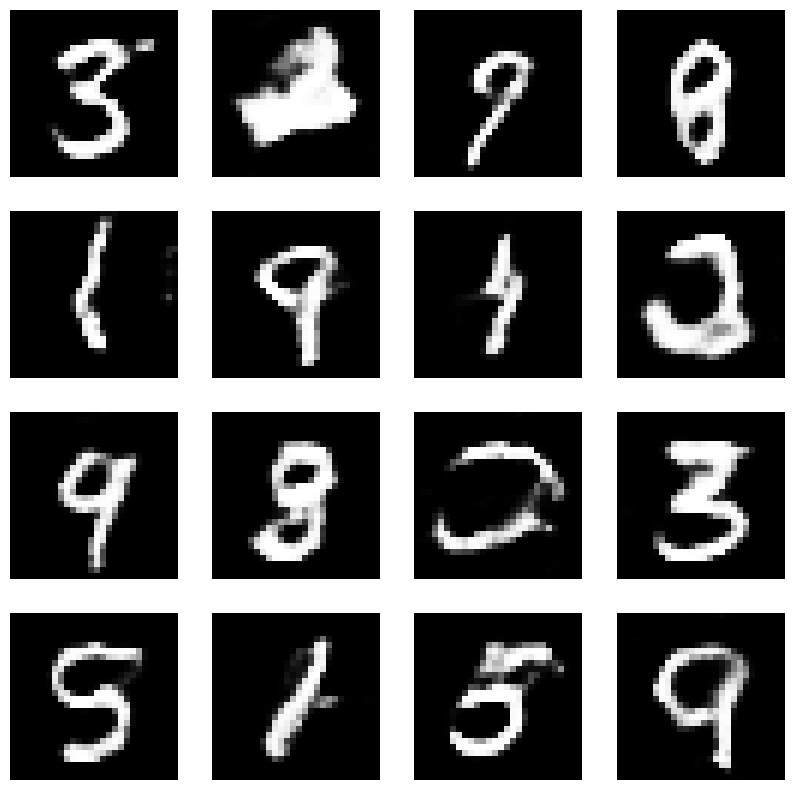

Weights saved and files closed for epoch 47
Epoch:  49


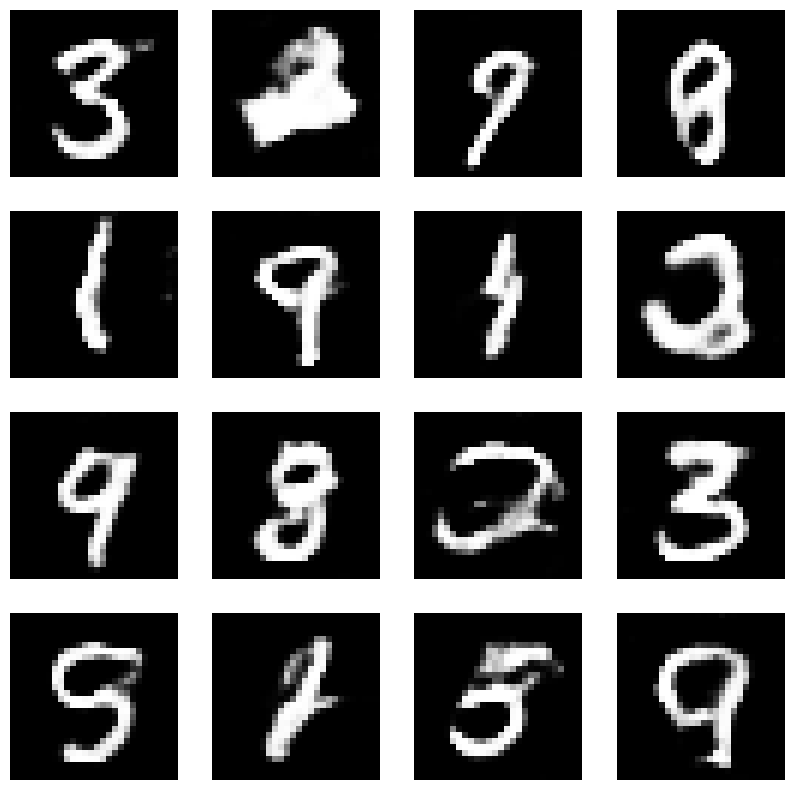

Weights saved and files closed for epoch 48
Epoch:  50


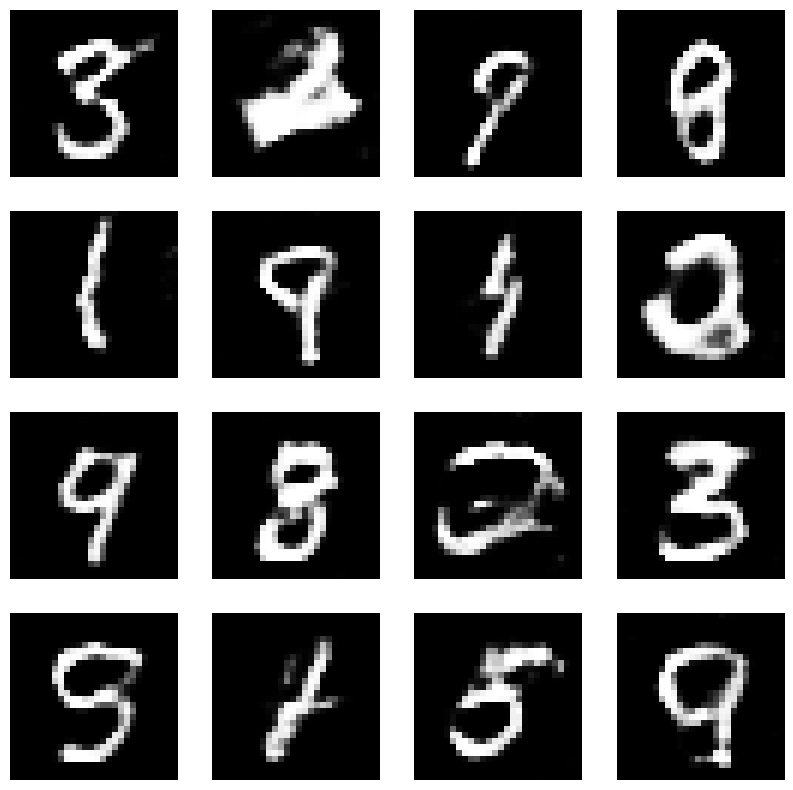

Weights saved and files closed for epoch 49
Epoch:  51


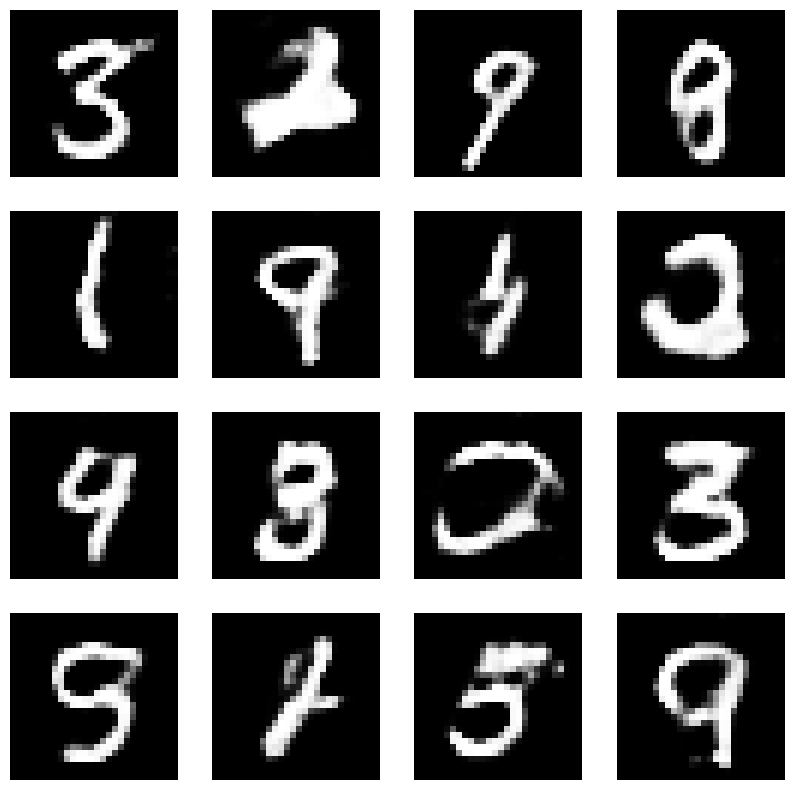

Weights saved and files closed for epoch 50
Epoch:  52


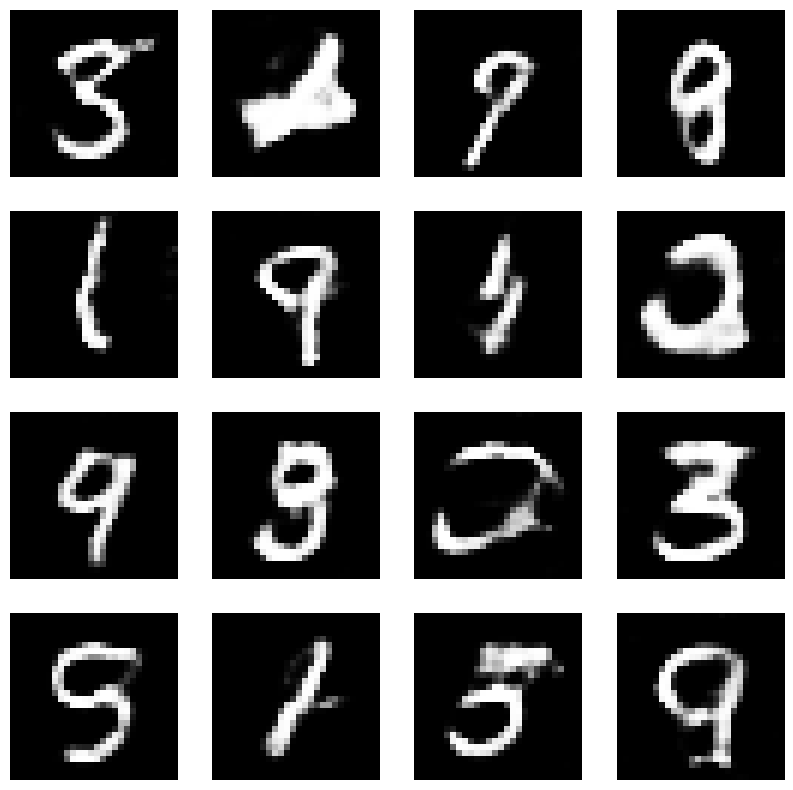

Weights saved and files closed for epoch 51
Epoch:  53


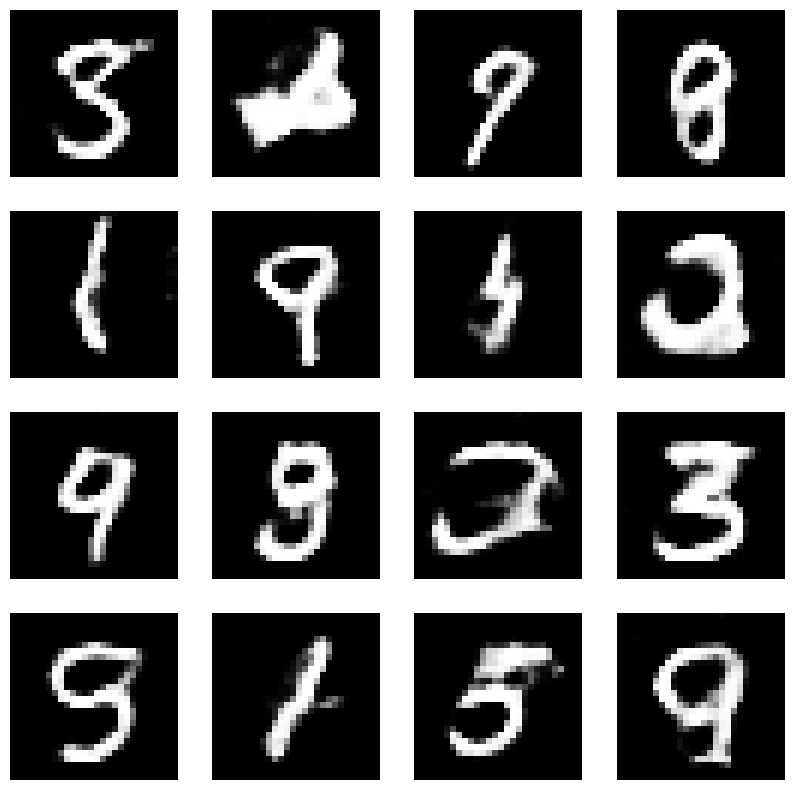

Weights saved and files closed for epoch 52
Epoch:  54


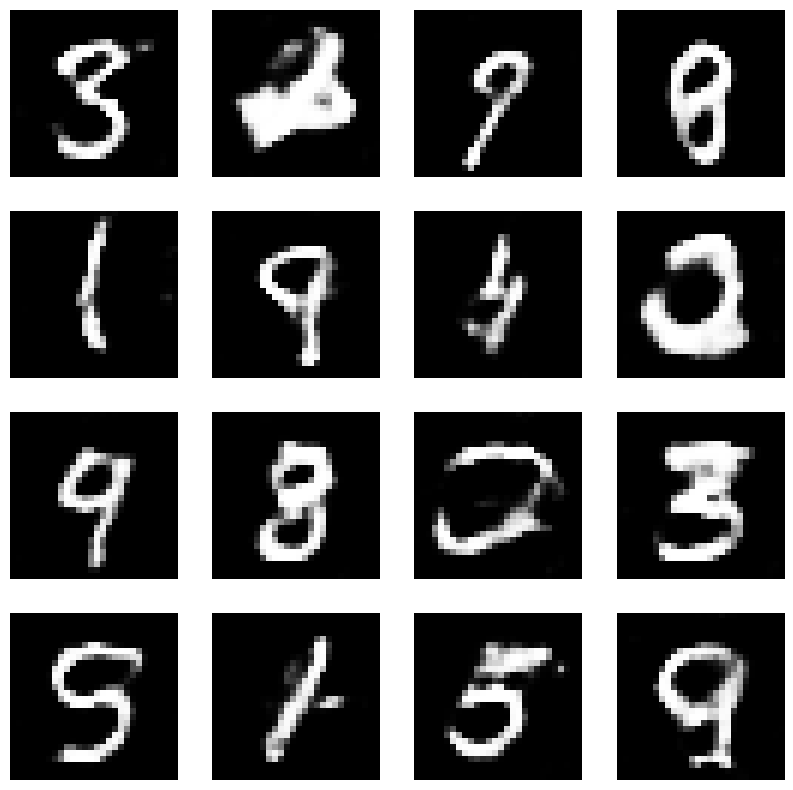

Weights saved and files closed for epoch 53
Epoch:  55


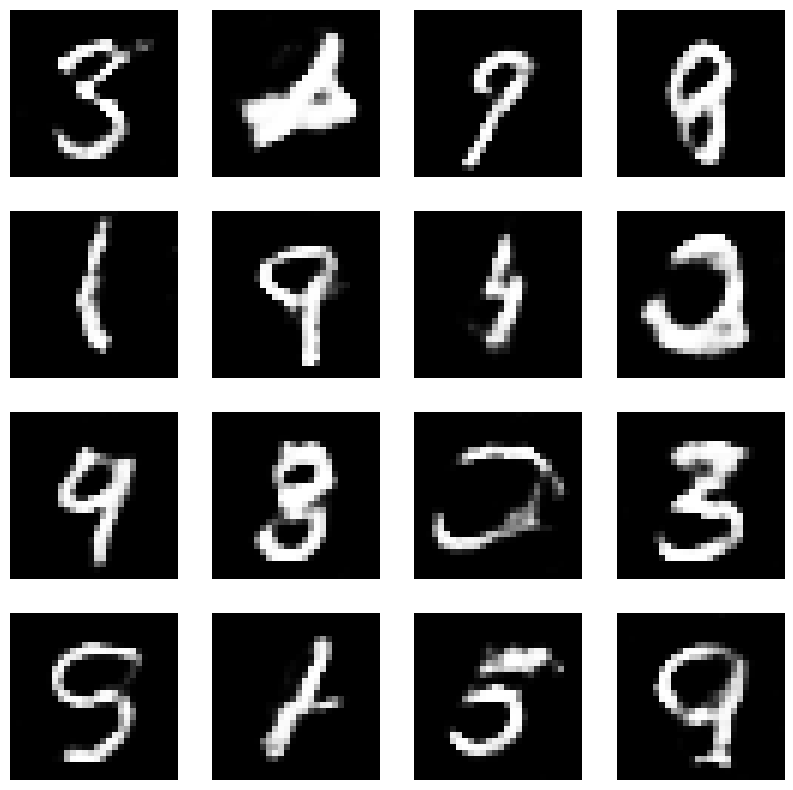

Weights saved and files closed for epoch 54
Epoch:  56


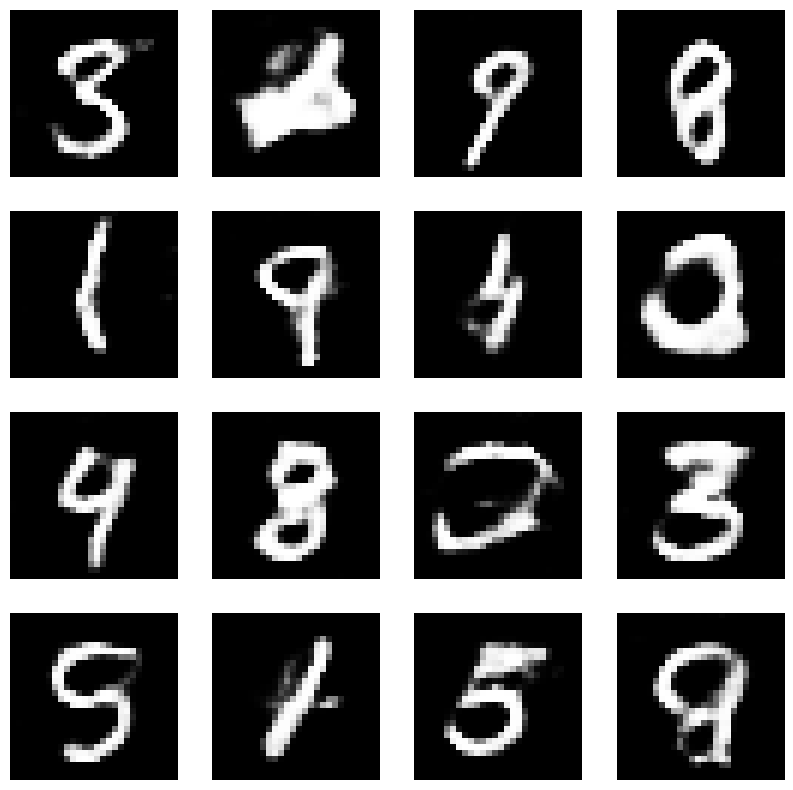

Weights saved and files closed for epoch 55
Epoch:  57


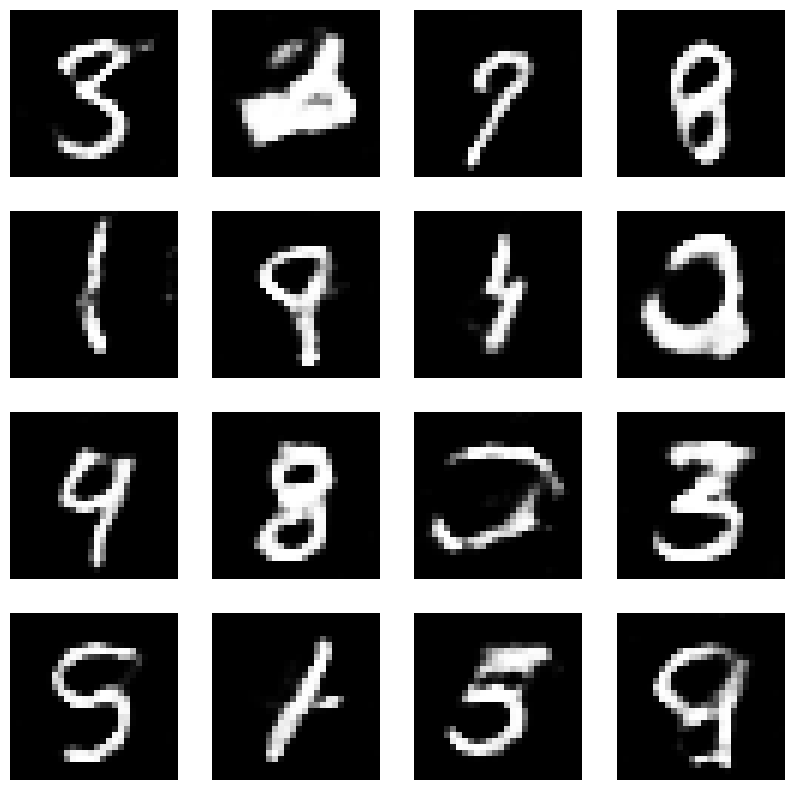

Weights saved and files closed for epoch 56
Epoch:  58


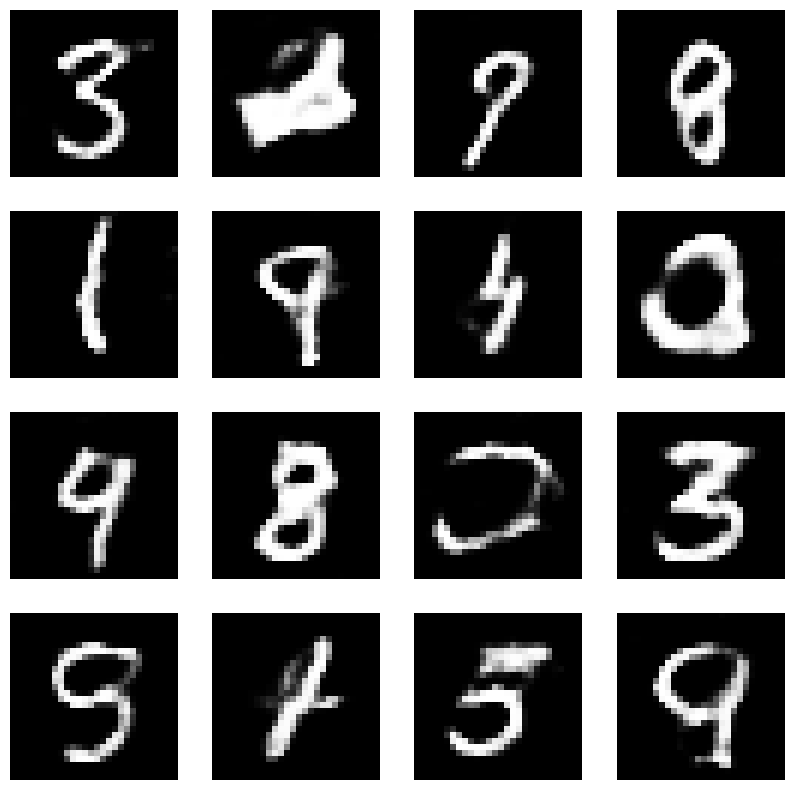

Weights saved and files closed for epoch 57
Epoch:  59


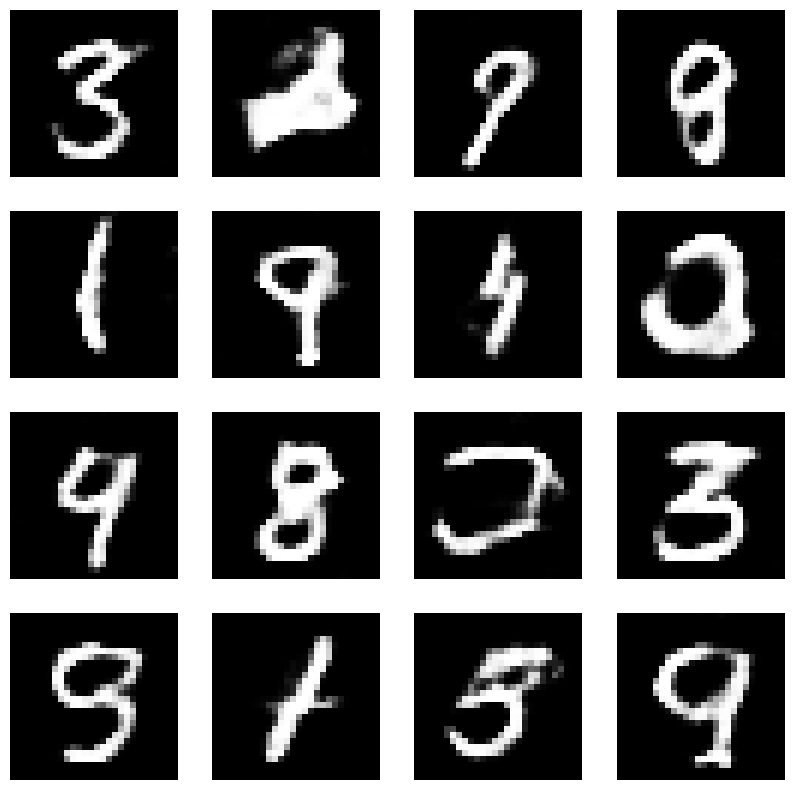

Weights saved and files closed for epoch 58
Epoch:  60


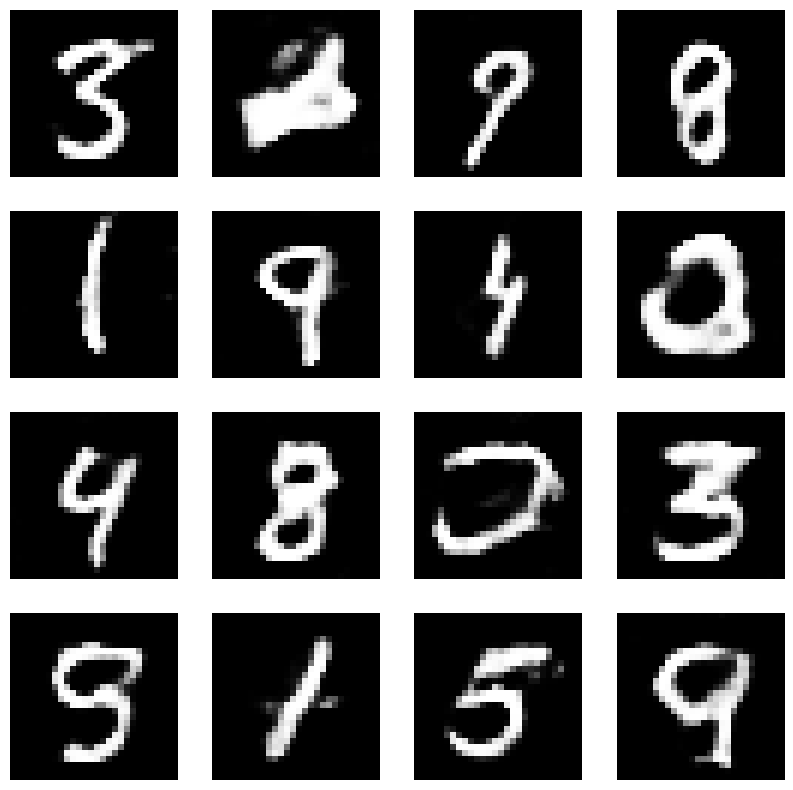

Weights saved and files closed for epoch 59
Epoch:  61


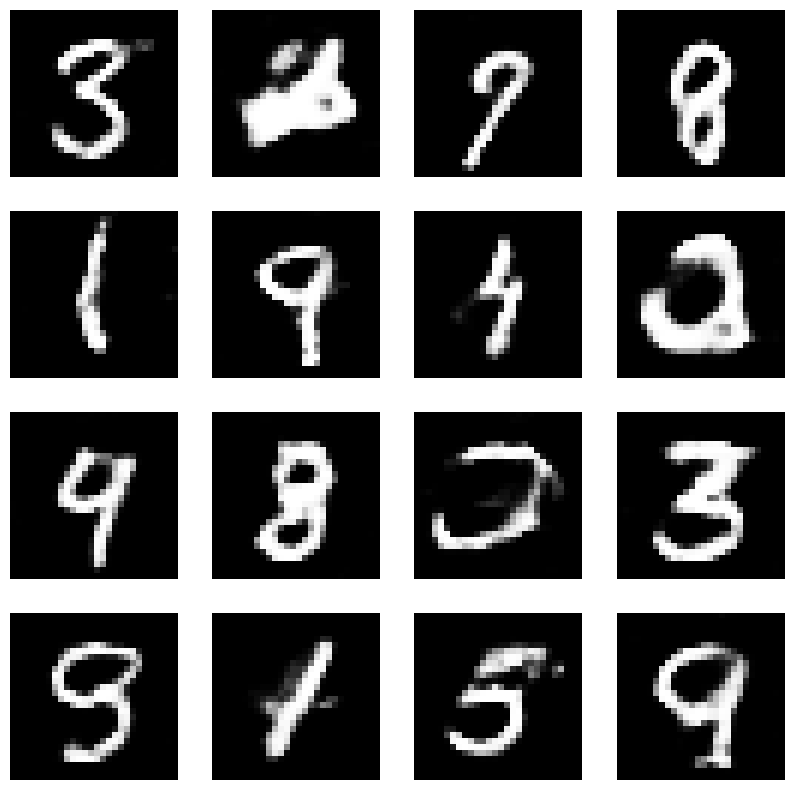

Weights saved and files closed for epoch 60
Epoch:  62


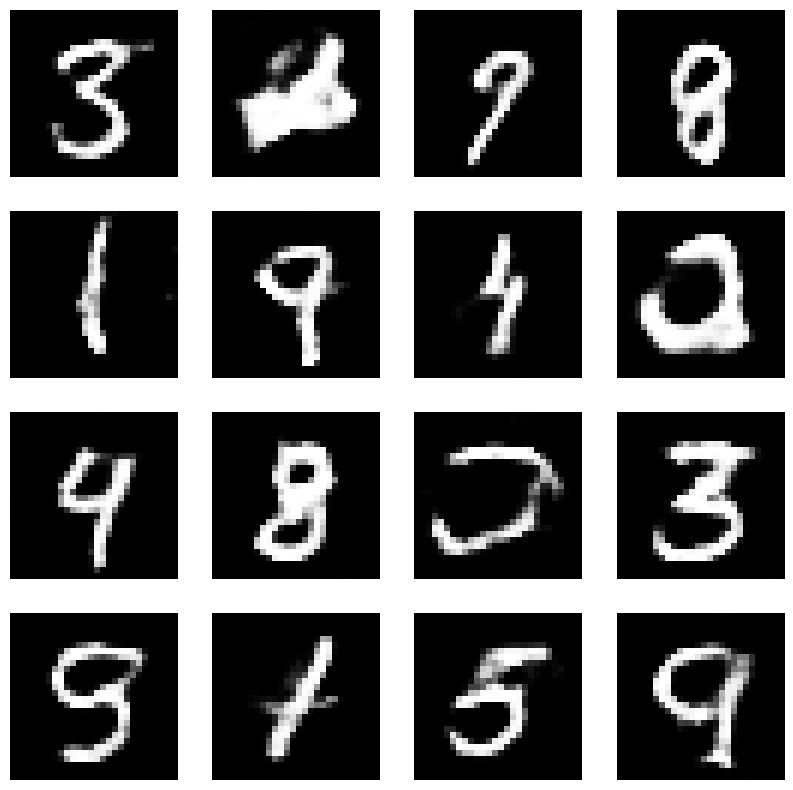

Weights saved and files closed for epoch 61
Epoch:  63


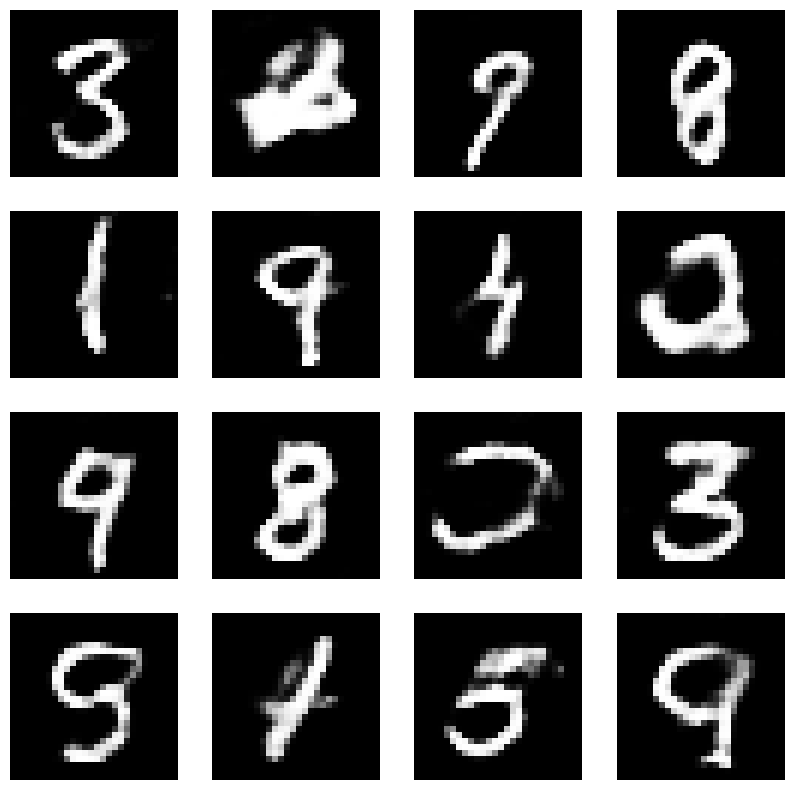

Weights saved and files closed for epoch 62
Epoch:  64


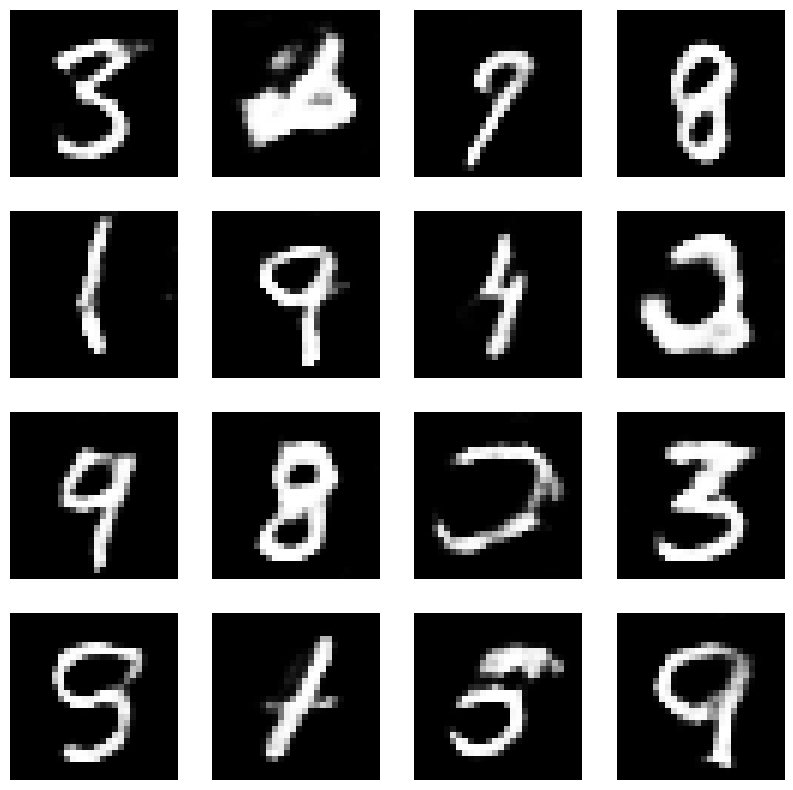

Weights saved and files closed for epoch 63
Epoch:  65


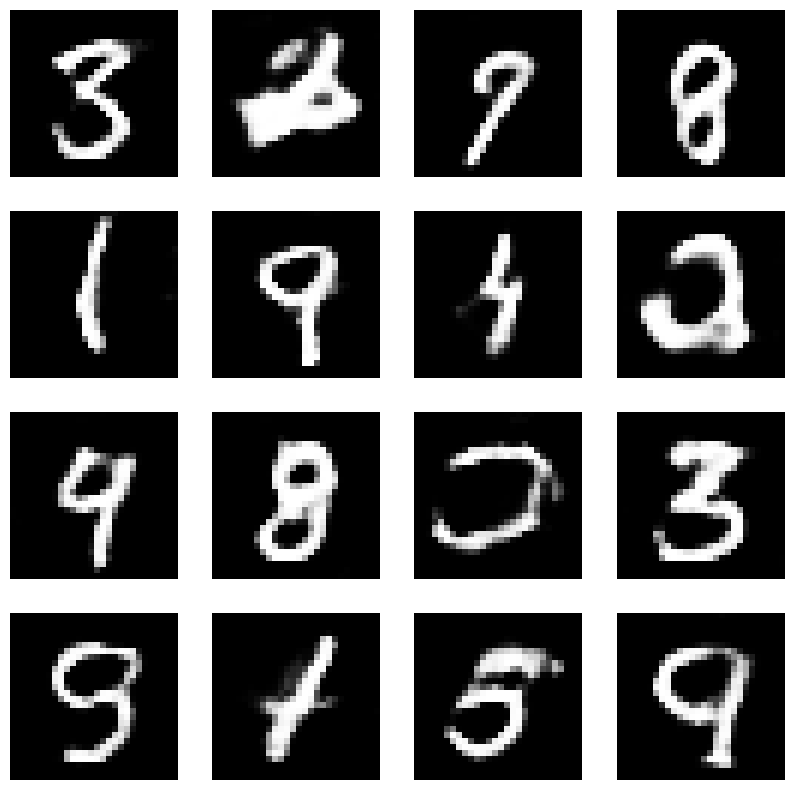

Weights saved and files closed for epoch 64
Epoch:  66


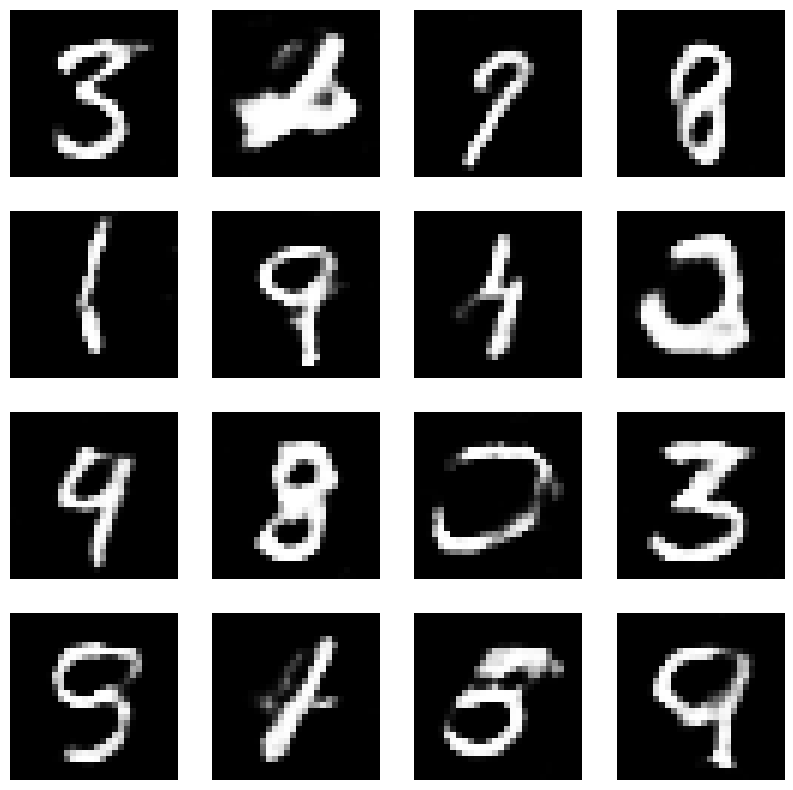

Weights saved and files closed for epoch 65
Epoch:  67


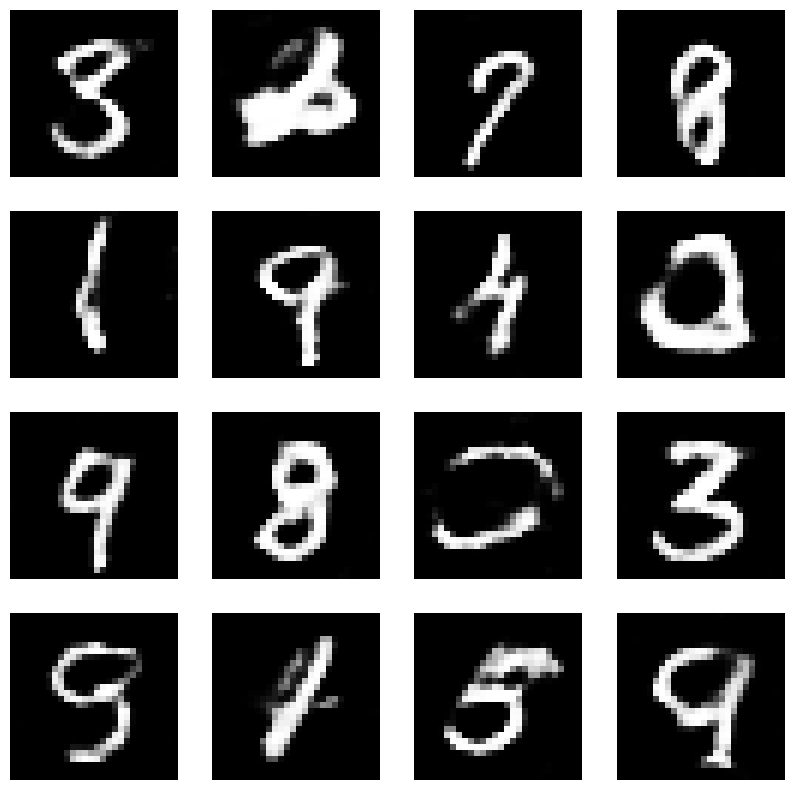

Weights saved and files closed for epoch 66
Epoch:  68


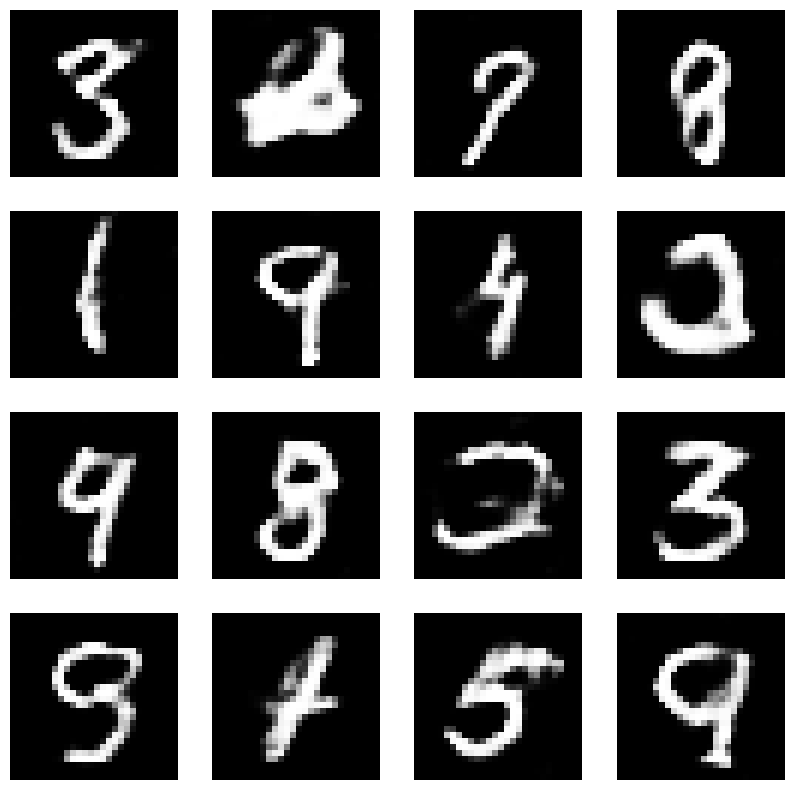

Weights saved and files closed for epoch 67
Epoch:  69


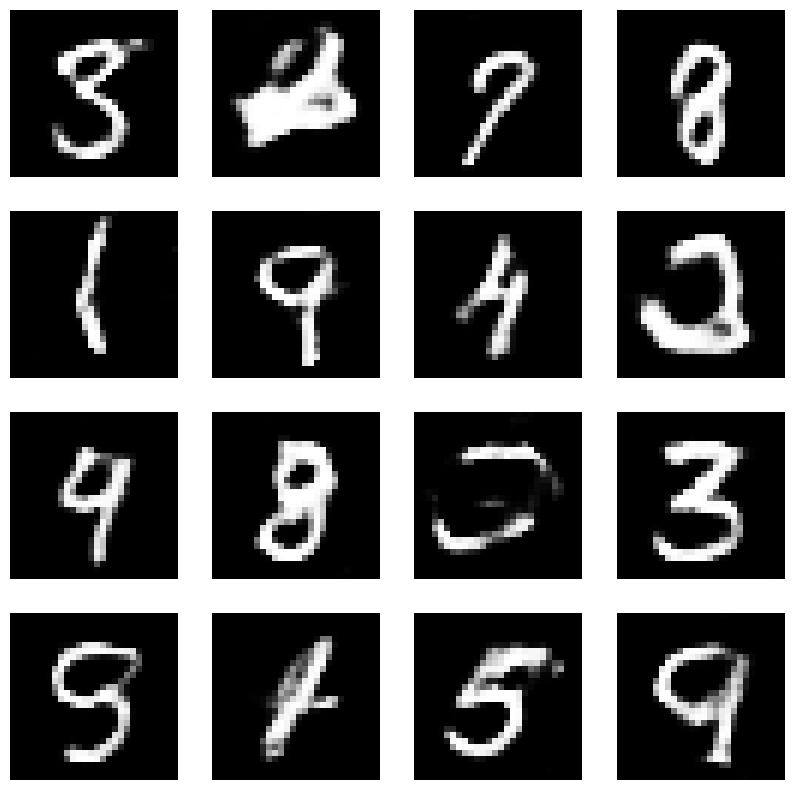

Weights saved and files closed for epoch 68
Epoch:  70


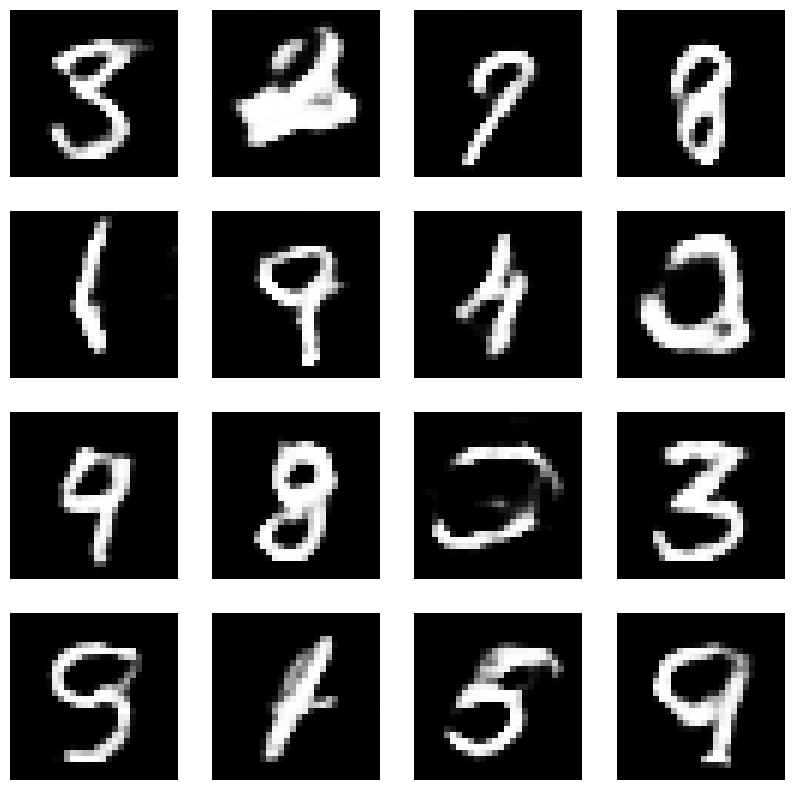

Weights saved and files closed for epoch 69
Epoch:  71


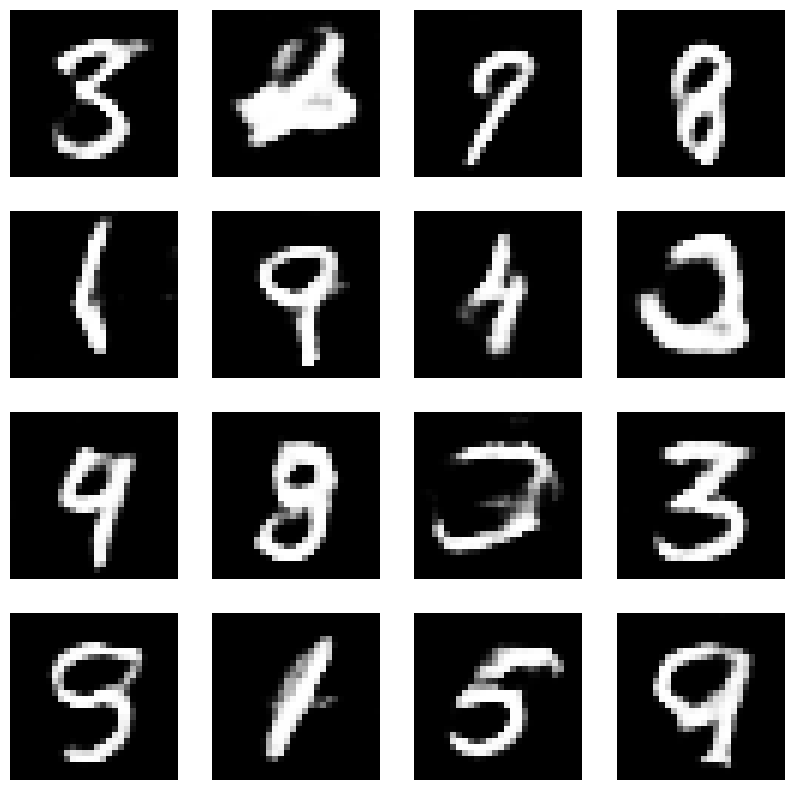

Weights saved and files closed for epoch 70
Epoch:  72


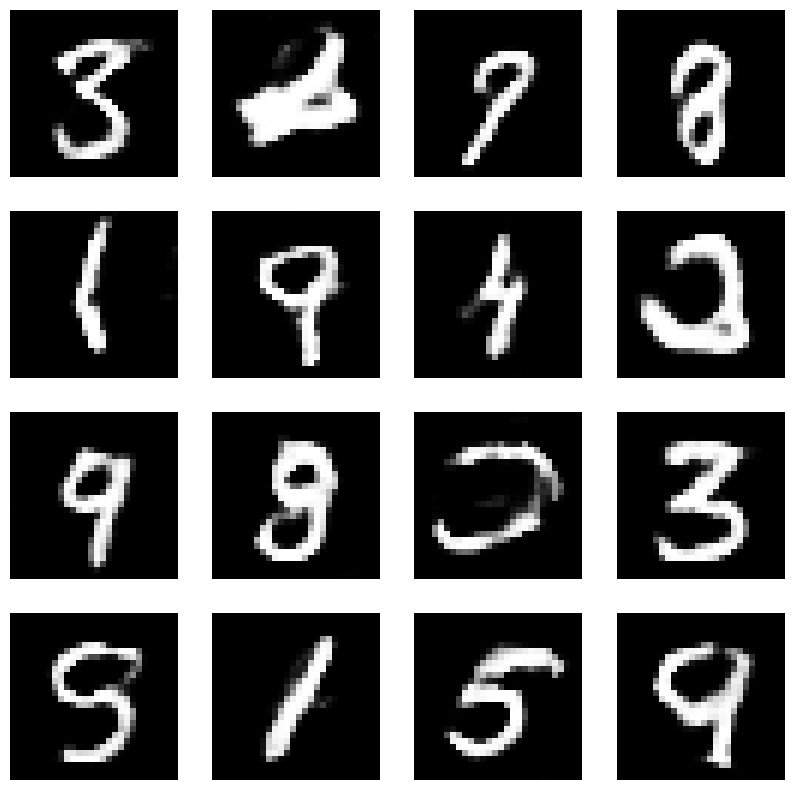

Weights saved and files closed for epoch 71
Epoch:  73


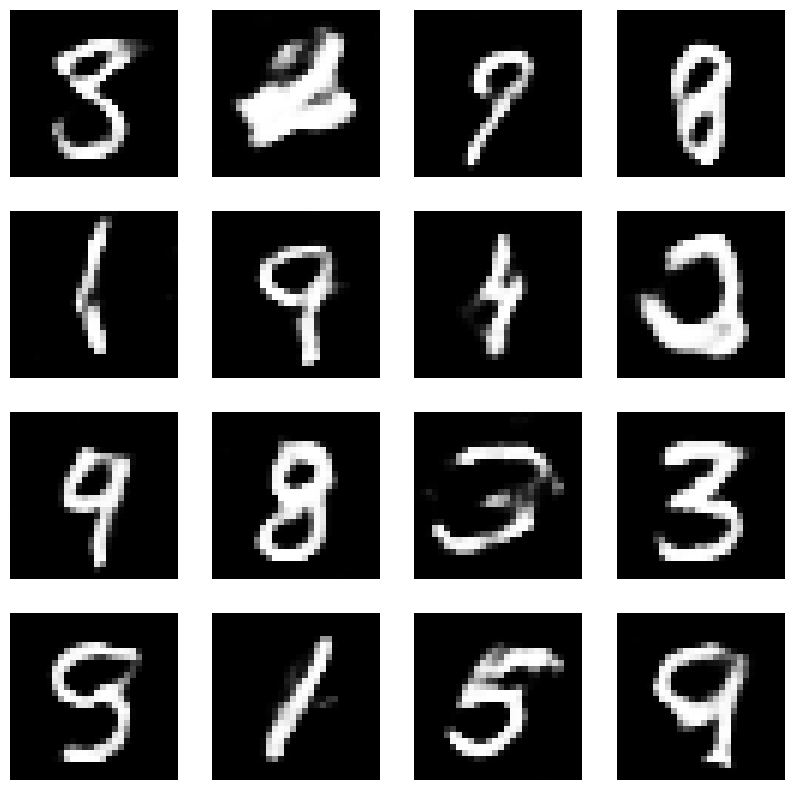

Weights saved and files closed for epoch 72
Epoch:  74


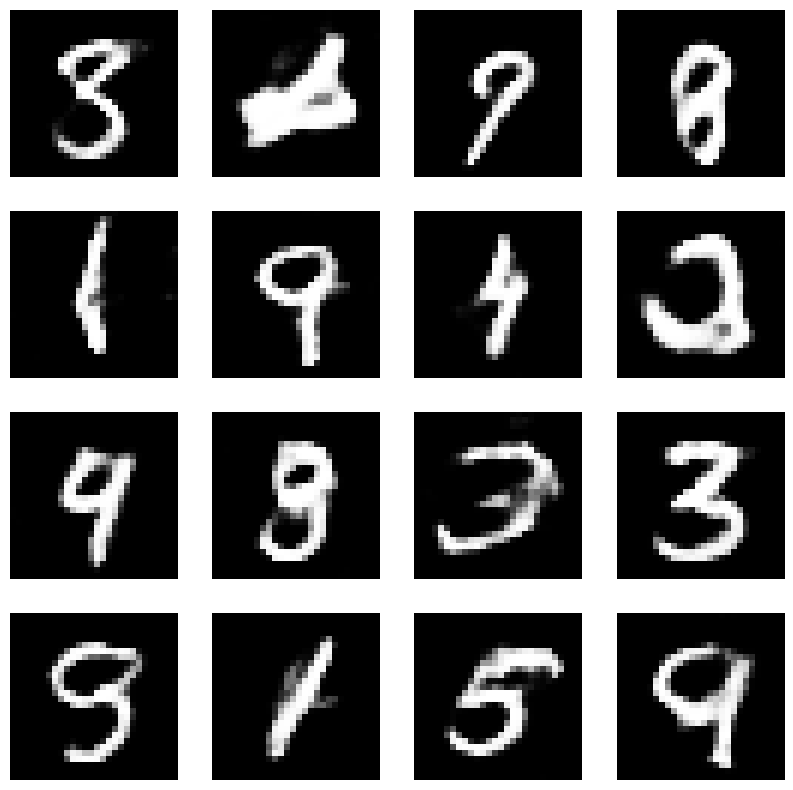

Weights saved and files closed for epoch 73
Epoch:  75


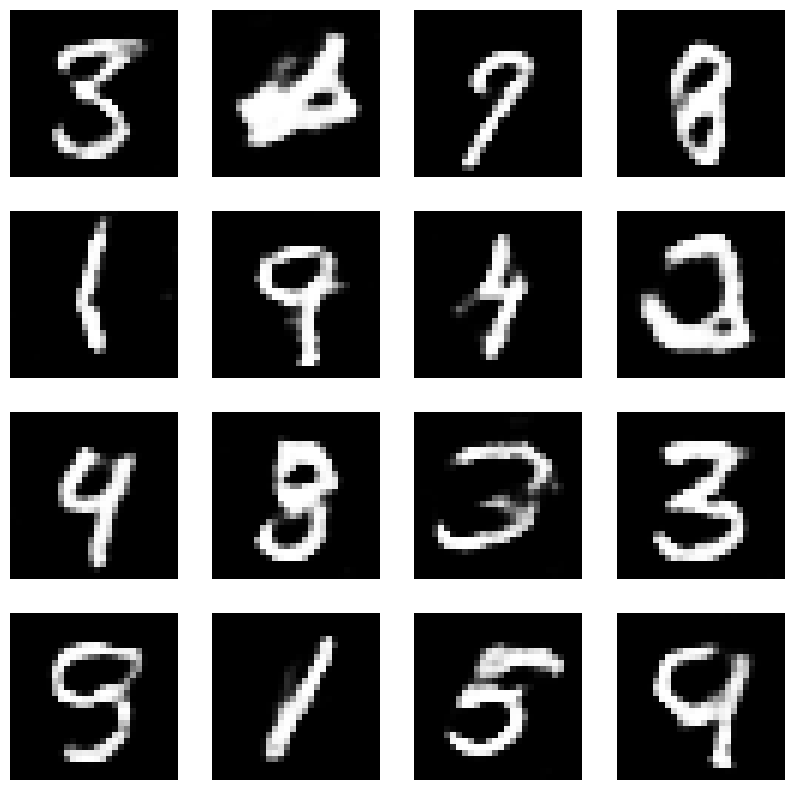

Weights saved and files closed for epoch 74
Epoch:  76


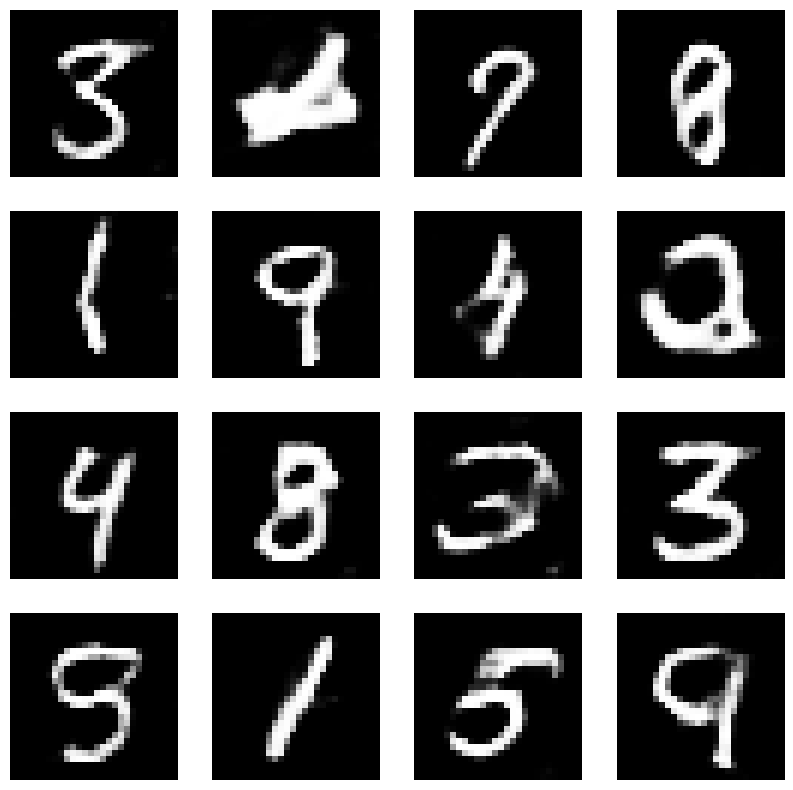

Weights saved and files closed for epoch 75
Epoch:  77


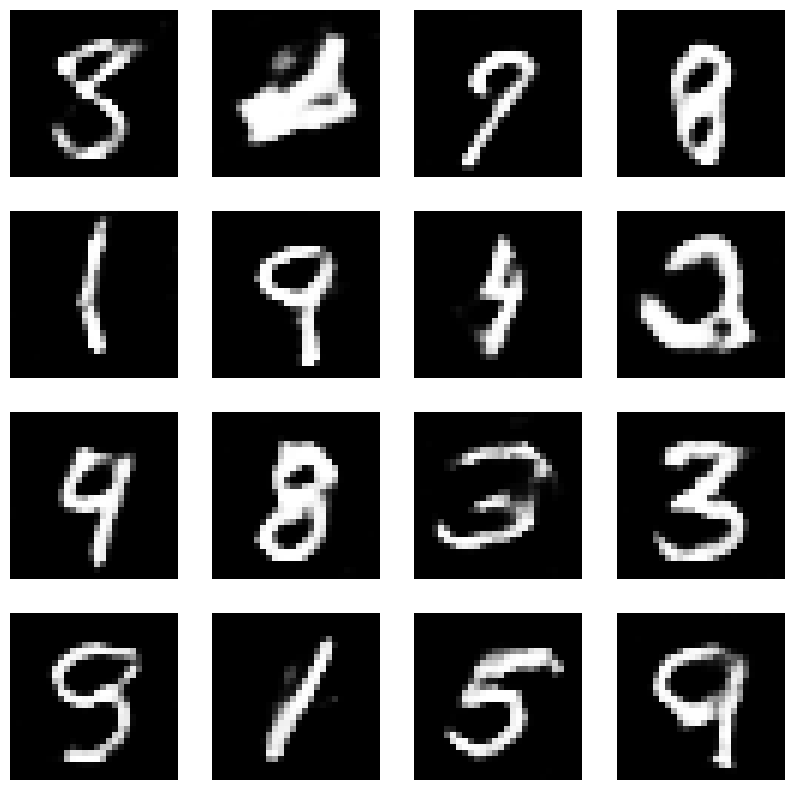

Weights saved and files closed for epoch 76
Epoch:  78


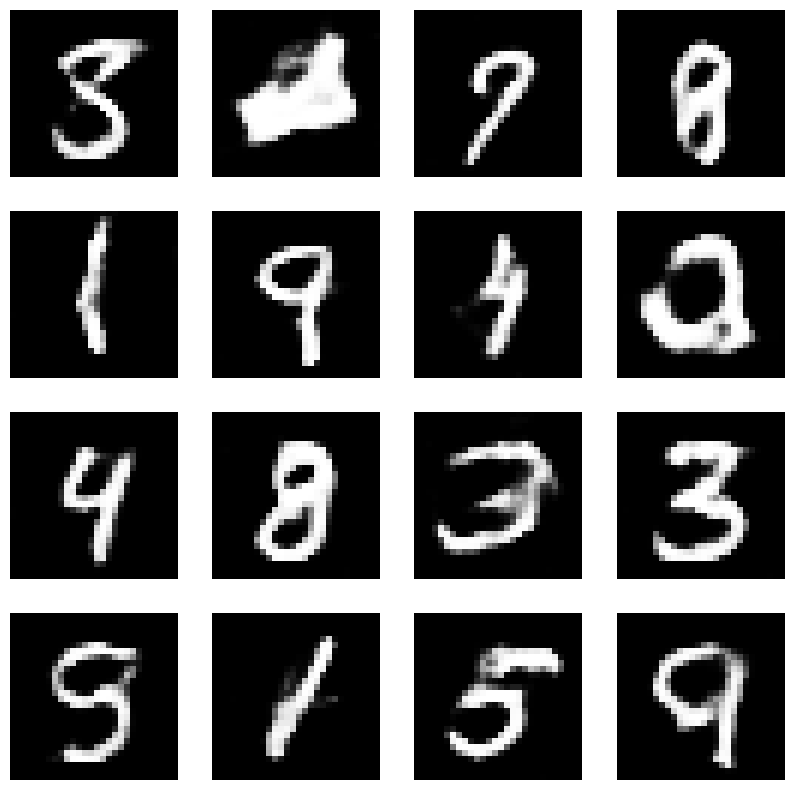

Weights saved and files closed for epoch 77
Epoch:  79


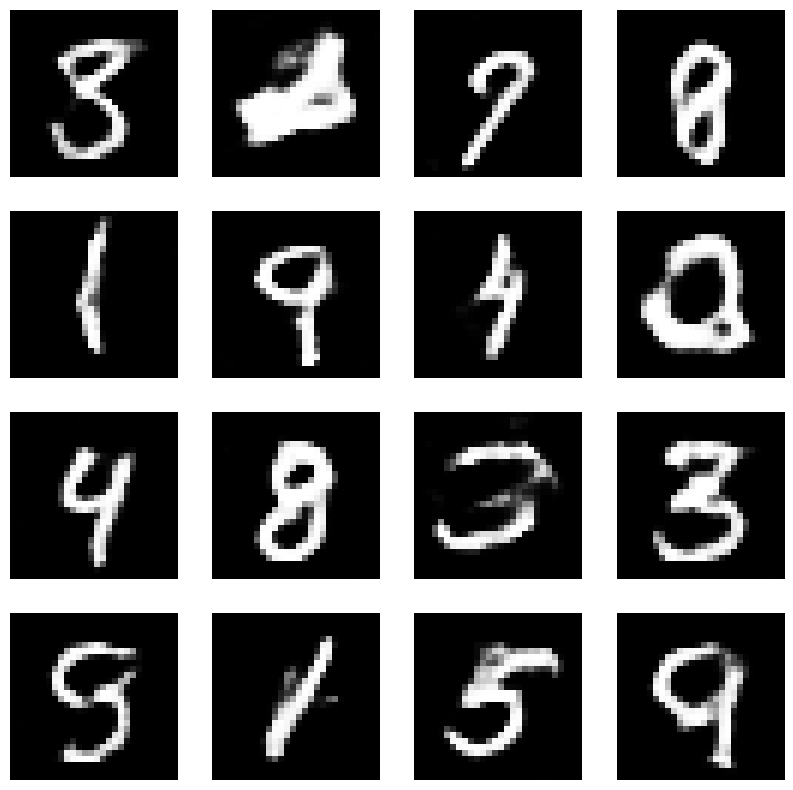

Weights saved and files closed for epoch 78
Epoch:  80


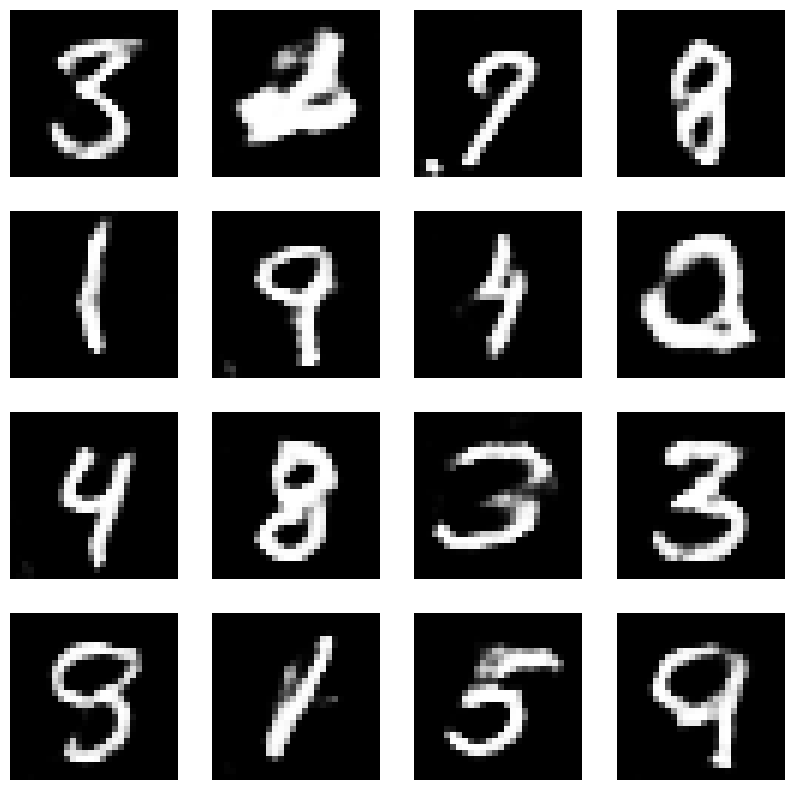

Weights saved and files closed for epoch 79
Epoch:  81


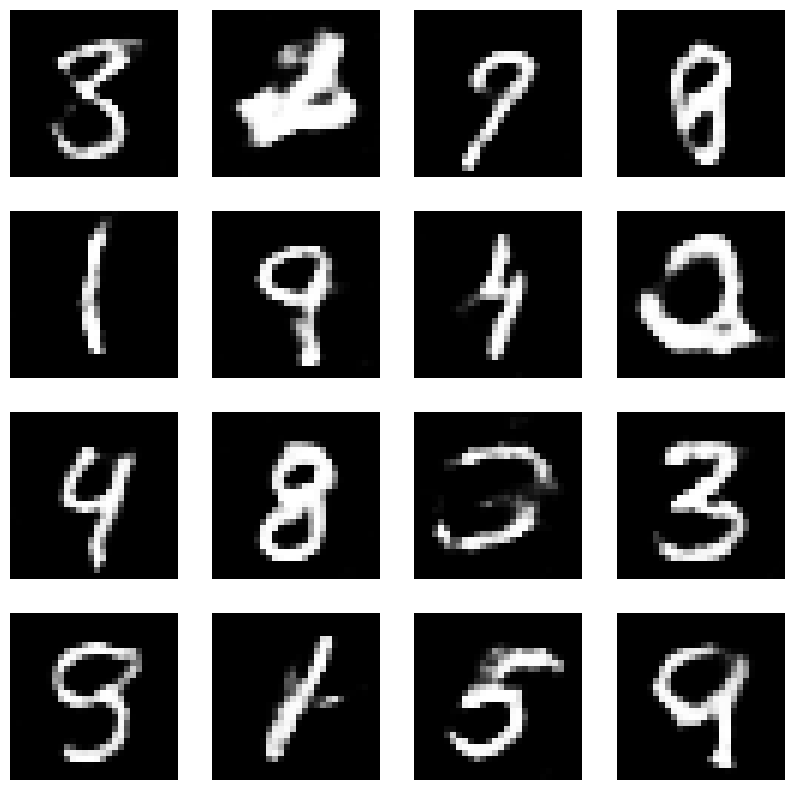

Weights saved and files closed for epoch 80
Epoch:  82


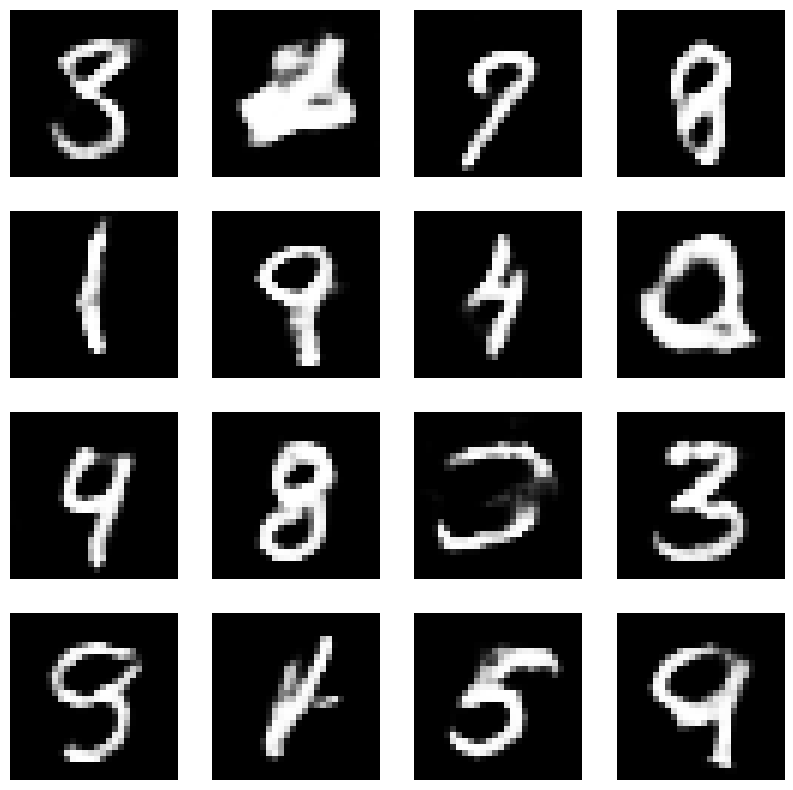

Weights saved and files closed for epoch 81
Epoch:  83


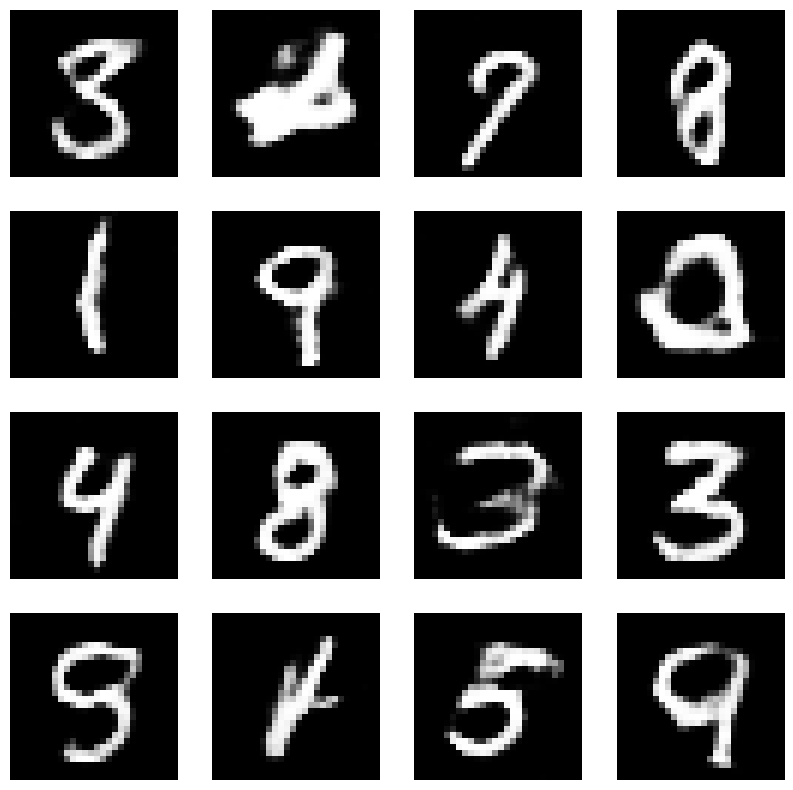

Weights saved and files closed for epoch 82
Epoch:  84


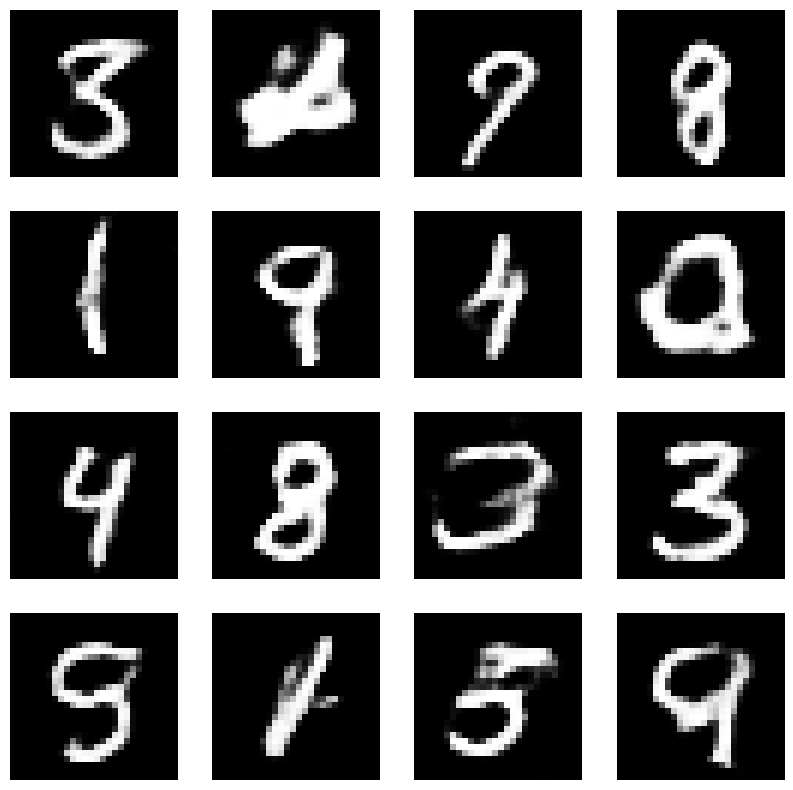

Weights saved and files closed for epoch 83
Epoch:  85


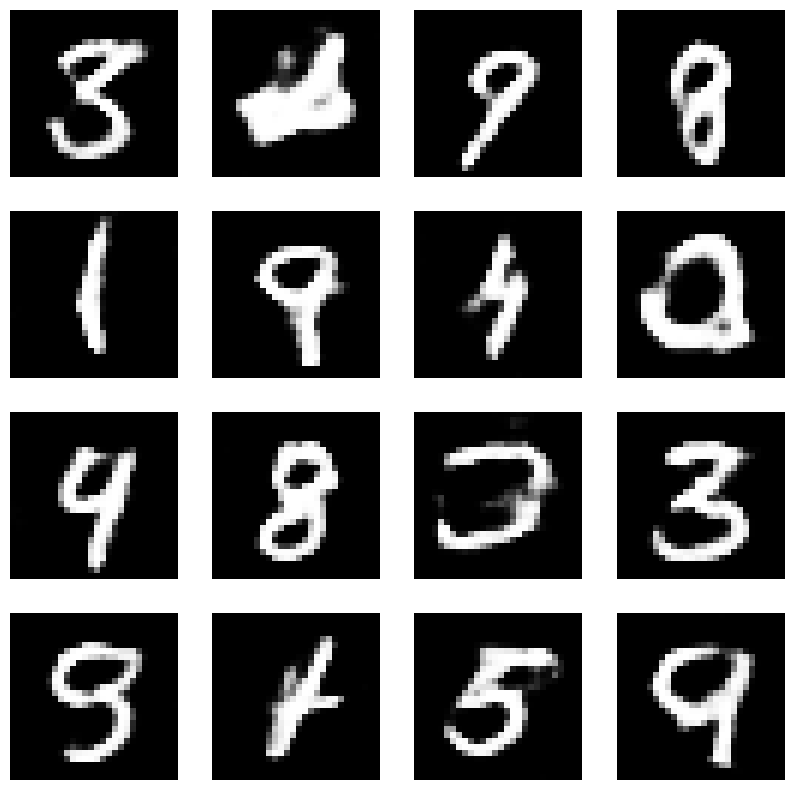

Weights saved and files closed for epoch 84
Epoch:  86


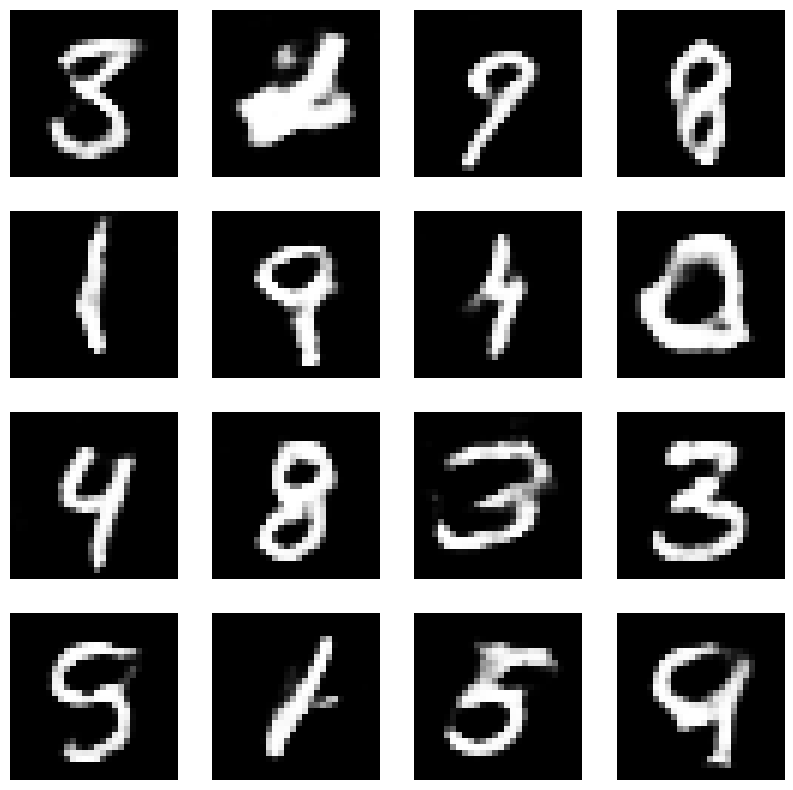

Weights saved and files closed for epoch 85
Epoch:  87


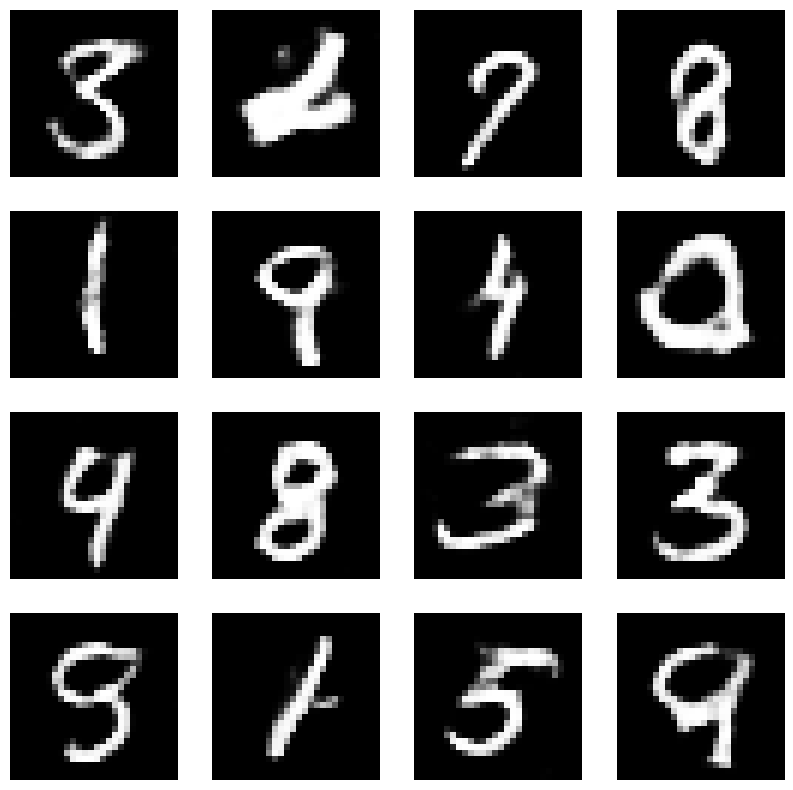

Weights saved and files closed for epoch 86
Epoch:  88


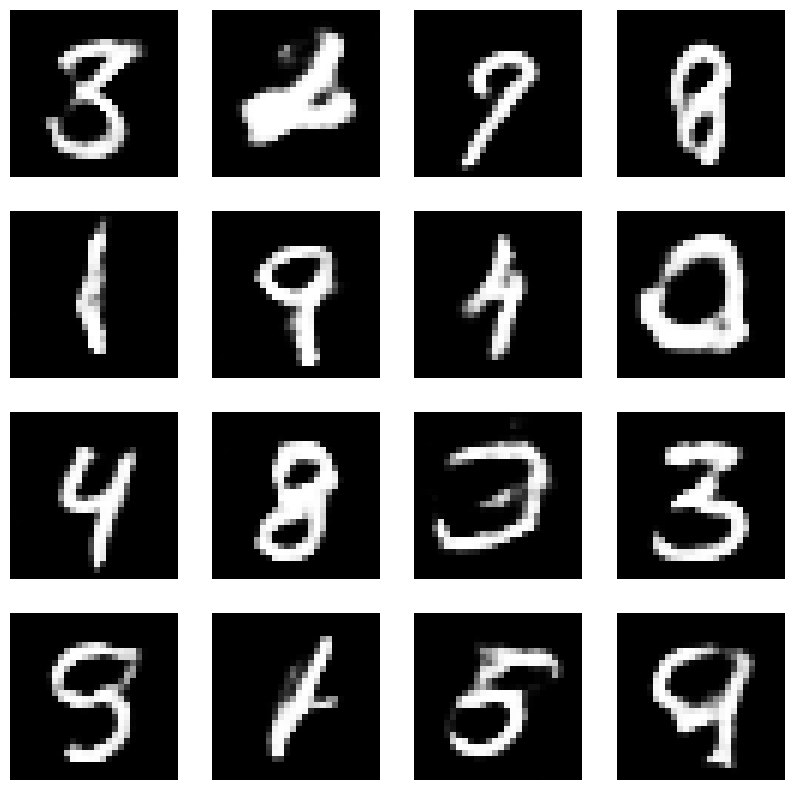

Weights saved and files closed for epoch 87
Epoch:  89


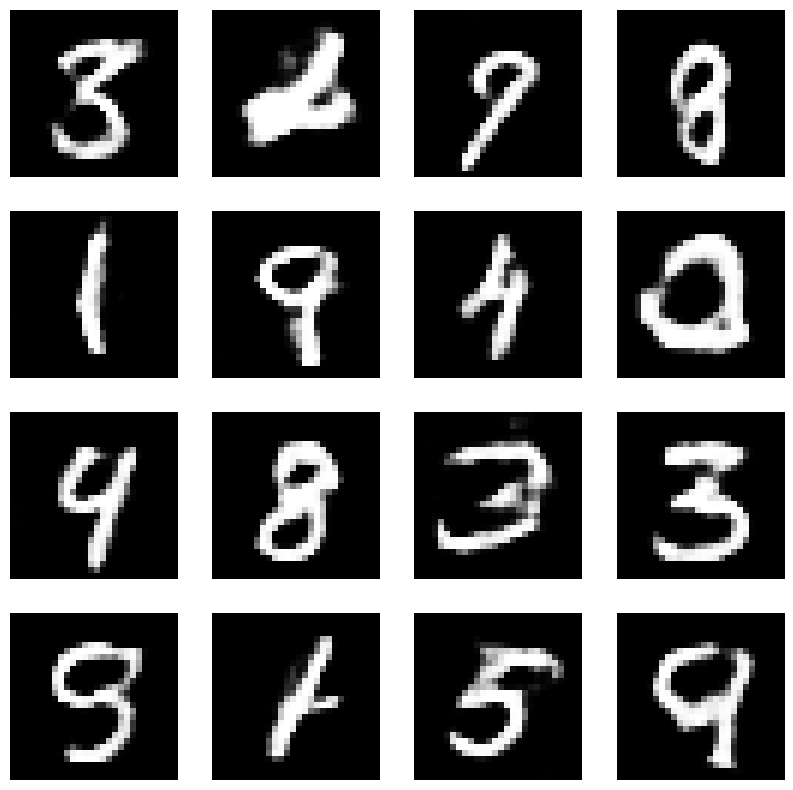

Weights saved and files closed for epoch 88
Epoch:  90


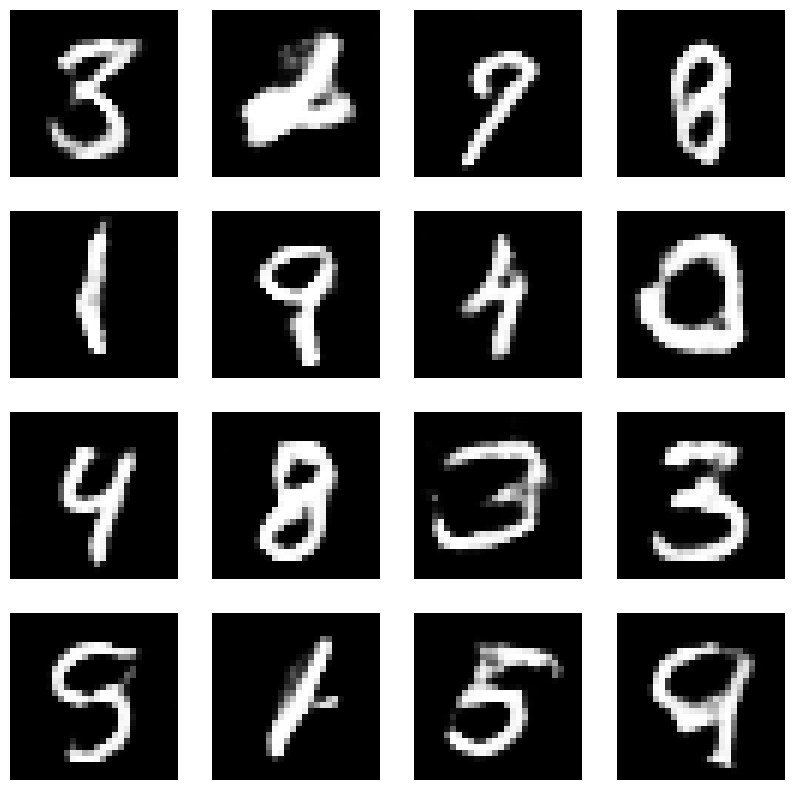

Weights saved and files closed for epoch 89
Epoch:  91


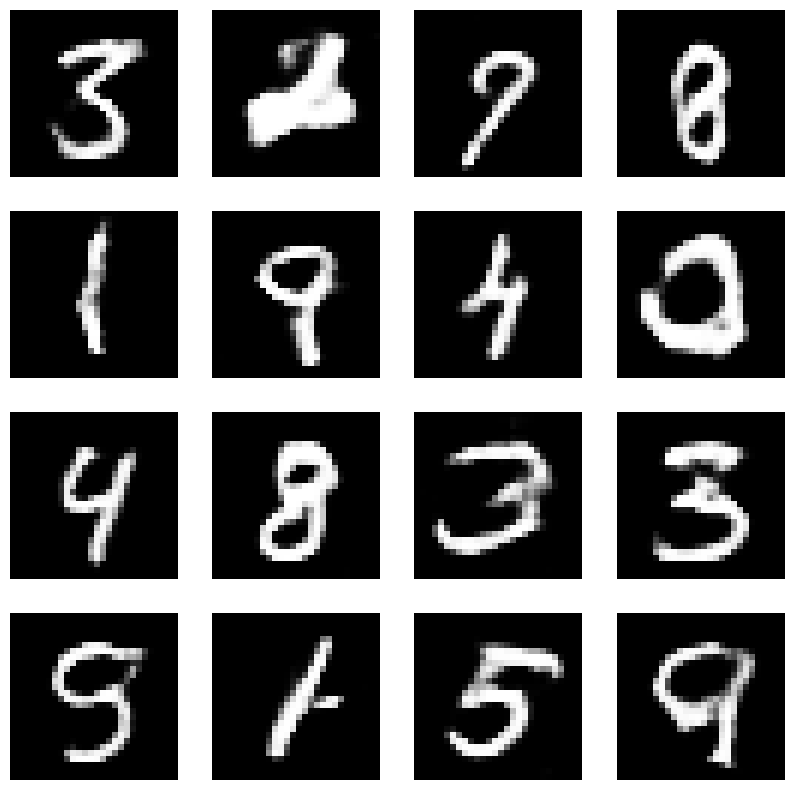

Weights saved and files closed for epoch 90
Epoch:  92


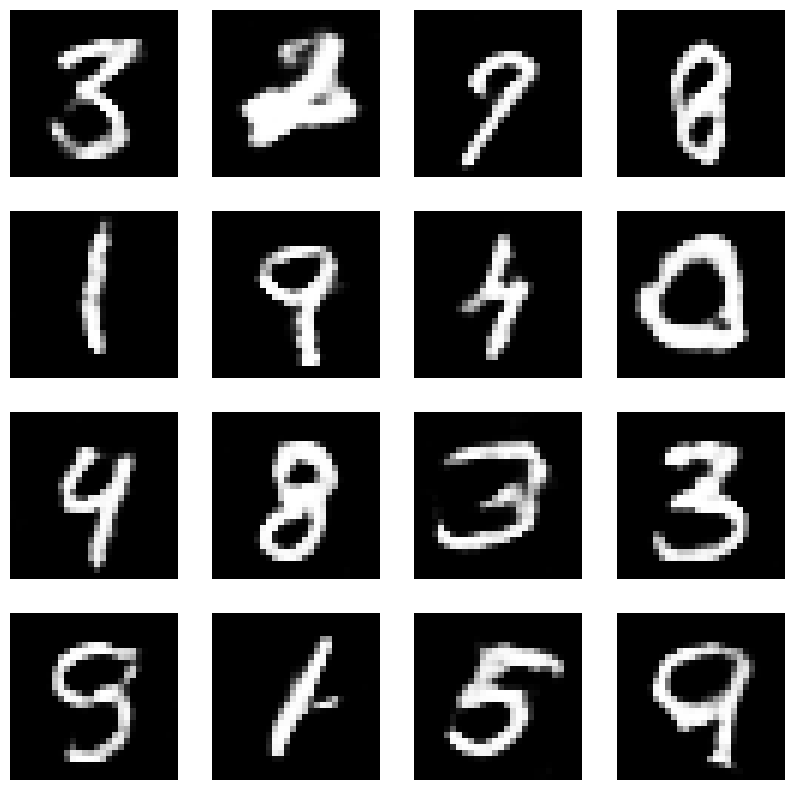

Weights saved and files closed for epoch 91
Epoch:  93


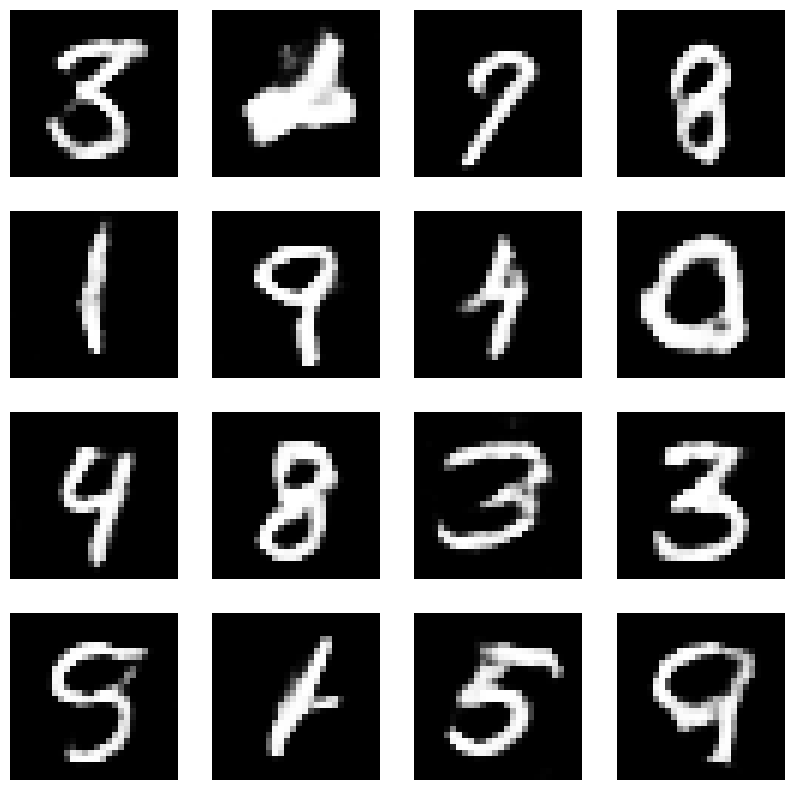

Weights saved and files closed for epoch 92
Epoch:  94


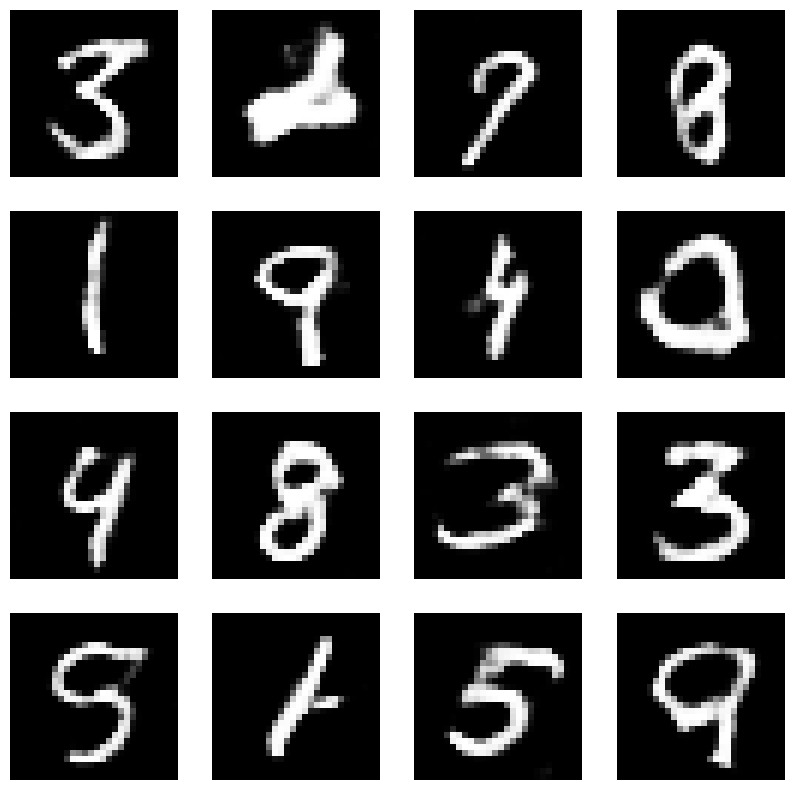

Weights saved and files closed for epoch 93
Epoch:  95


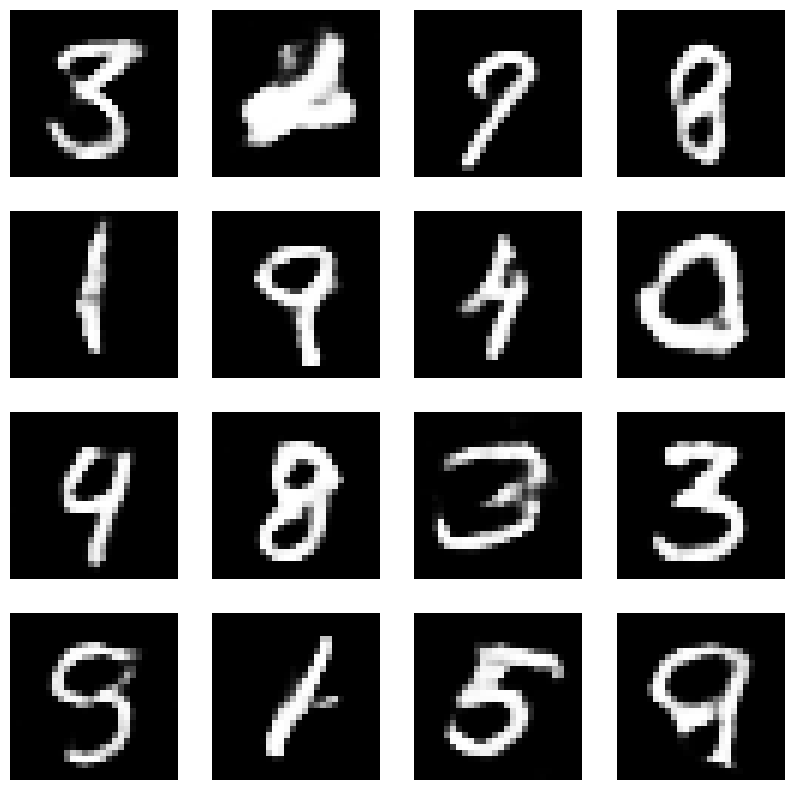

Weights saved and files closed for epoch 94
Epoch:  96


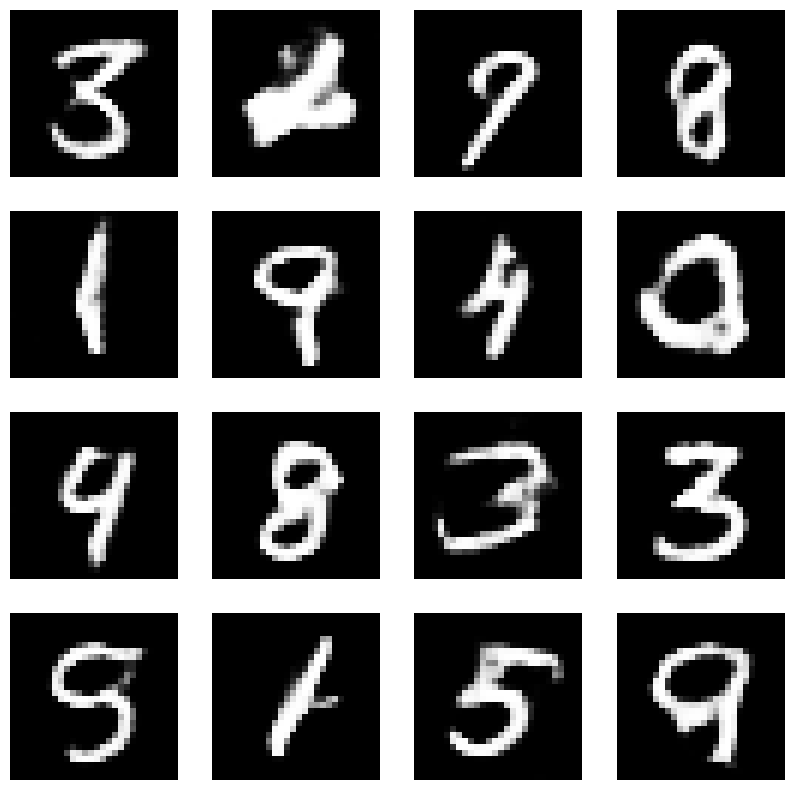

Weights saved and files closed for epoch 95
Epoch:  97


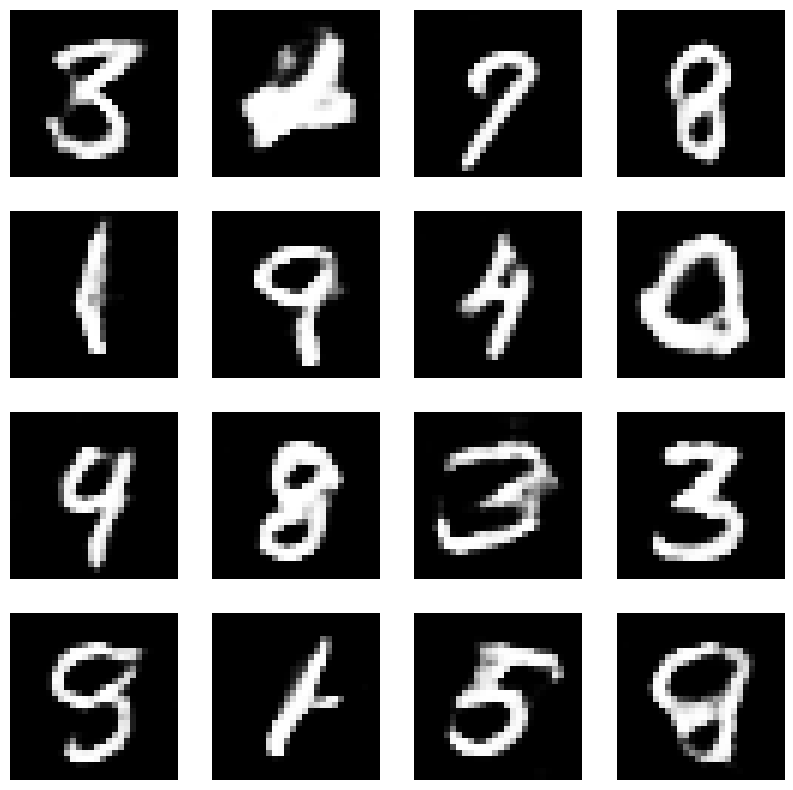

Weights saved and files closed for epoch 96
Epoch:  98


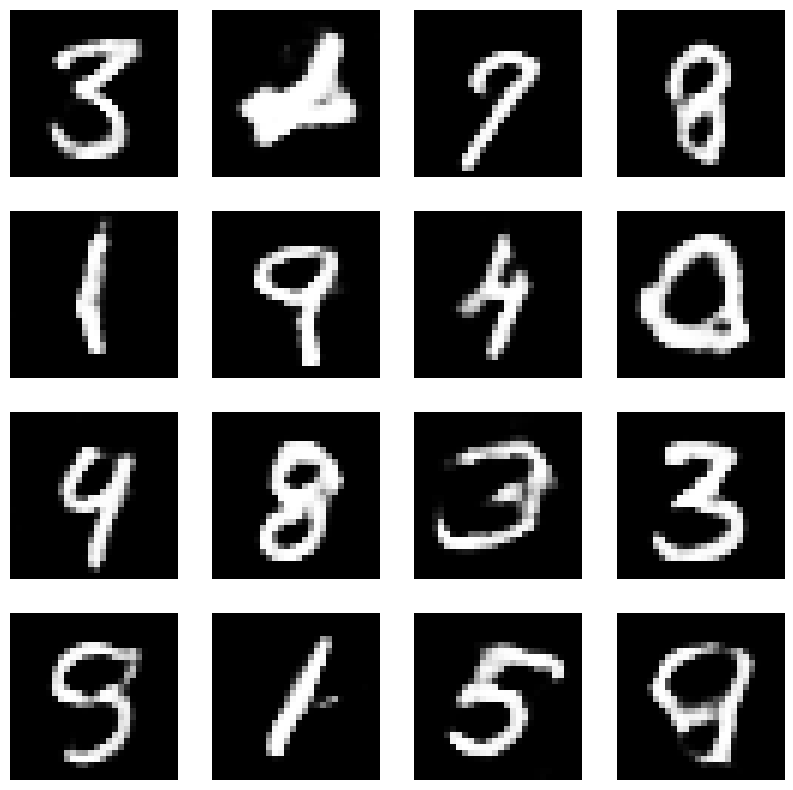

Weights saved and files closed for epoch 97
Epoch:  99


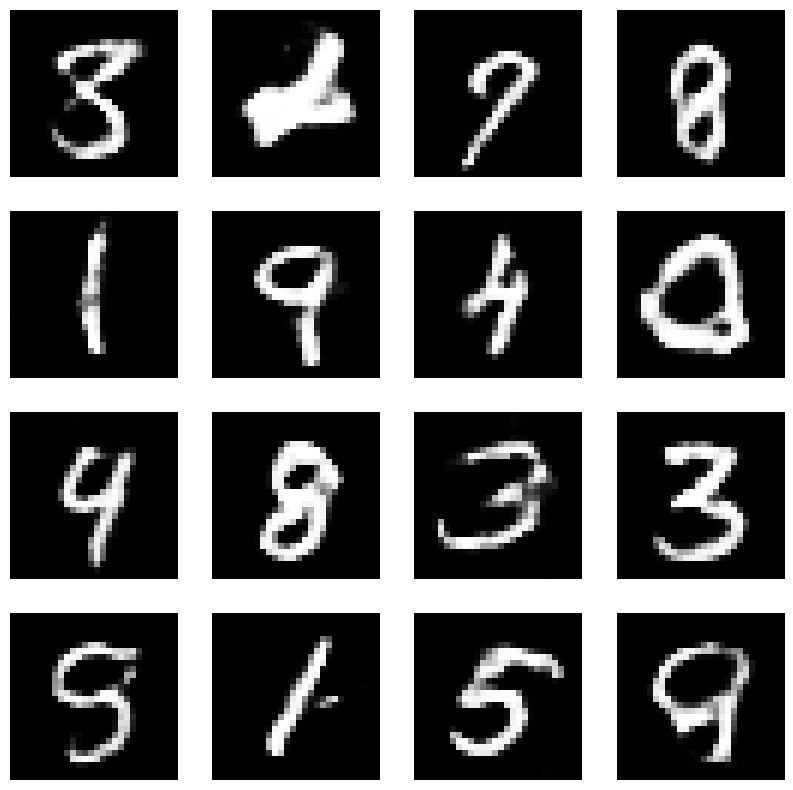

Weights saved and files closed for epoch 98
Epoch:  100


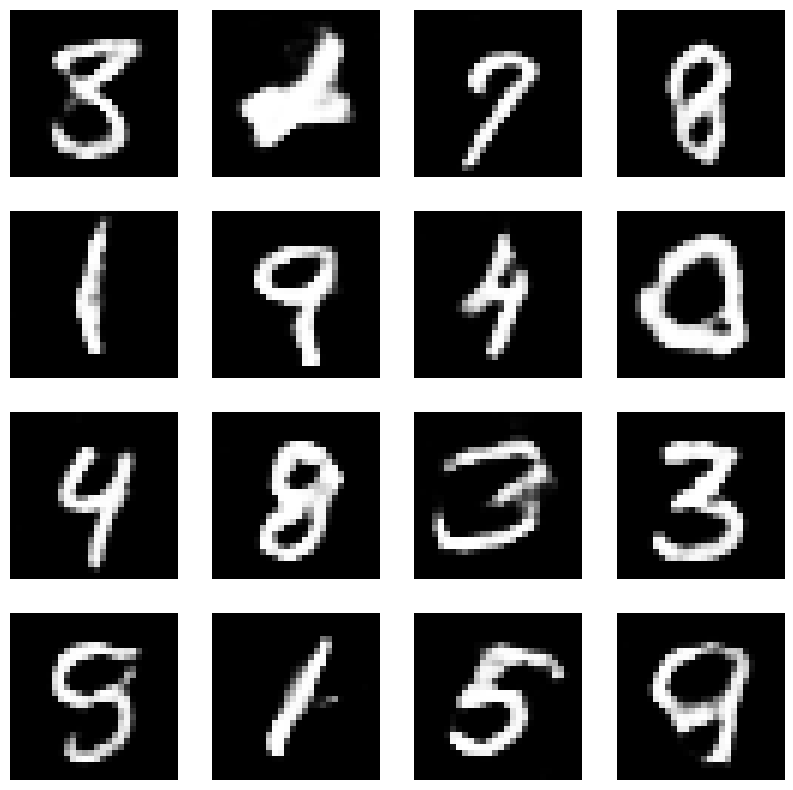

Weights saved and files closed for epoch 99


In [44]:
train(X_train, epochs, test_images)

Experiment with:
1. hyperparameter tuning
2. changing neurons no.
3. changing no. of layers
4. changing size of randomized img. eg 100->200

In [ ]:
 if epoch % 5 == 0:
    gen_file = f"{checkpoint_dir}/generator_weights_epoch_{epoch}.weights.h5"
    disc_file = f"{checkpoint_dir}/discriminator_weights_epoch_{epoch}.weights.h5"
